# Do Interictal Discharges Affect Functional Connectivity

author: Jeni Stiso (jeni.stiso@gmail.com)

words

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from statsmodels.stats.anova import AnovaRM
import palettable
import statsmodels.api as sm
from sklearn.metrics.pairwise import euclidean_distances

%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
sns.set_context('poster')
sns.set_style("whitegrid")

In [2]:
# directories - point this at you RAM data
RAM_dir = '/Volumes/bassett-data/Jeni/RAM/'
parcel_dir = '/Users/stiso/Documents/parcellations/'
win = 1
detector = '' # '_delphos' or ''

# load data
net_data = pd.read_csv(f'{RAM_dir}group_analysis/win_{win}/network_stats{detector}.csv', index_col=0)
node_data = pd.read_csv(f'{RAM_dir}group_analysis/win_{win}/node_stats{detector}.csv', index_col=0)

# drop duplicates
net_data.drop_duplicates(inplace=True)
node_data.drop_duplicates(inplace=True)

Check the data

In [3]:
net_data.head(10)

band_measure  n_tp  str_beta_bin  str_beta_num  str_soz_beta_bin  \
1         alpha_aec   107      0.854233     -0.308418          1.059740   
2   alpha_aec_ortho   107      0.418842     -0.041771          0.139267   
3         alpha_coh   107      0.590071     -0.136139          1.332877   
4      alpha_im_coh   107      0.546350     -0.091240          1.653054   
5         alpha_plv   107      1.382341     -0.571861          0.567091   
6          beta_aec   107     -0.241167     -0.055265         -0.172447   
7    beta_aec_ortho   107     -0.478895     -0.101653         -0.757854   
8          beta_coh   107     -1.400779      0.500620         -0.432153   
9       beta_im_coh   107     -1.777026      0.666524         -0.644009   
10         beta_plv   107     -0.163943     -0.016503          0.033498   

    str_soz_beta_num  str_not_soz_beta_num  str_spike_beta_num  \
1          -0.420497             -0.270865           -0.142973   
2          -0.032859             -0.025390            0.200103   
3          -0.490406             -0.045080            0.038881   
4          -0.569317              0.035525           -0.021692   
5          -0.355160             -0.562533           -0.177097   
6          -0.067385             -0.053229            0.043149   
7           0.091662             -0.190374           -0.071063   
8           0.107748              0.564379            1.149075   
9           0.178072              0.676593            1.159698   
10         -0.009530             -0.018310            0.190108   

    str_not_soz_beta_bin  str_spike_beta_bin  str_not_spike_beta_bin  \
1               0.792757            0.498661                0.891197   
2               0.288357           -0.733798                0.613691   
3               0.405967            0.215112                0.562521   
4               0.269452            0.261294                0.511519   
5               1.409217            0.125400                1.567178   
6              -0.215706           -0.657497               -0.123200   
7              -0.122962            0.061699               -0.363181   
8              -1.537868           -3.177229               -1.007633   
9              -1.792658           -3.081733               -1.369935   
10             -0.211830           -0.733566                0.137042   

   fc_measure  str_not_spike_beta_num   band    subj hand   age gender  race  
1         aec               -0.329908  alpha  R1170J    R  20.0      M   2.0  
2   aec_ortho               -0.107114  alpha  R1170J    R  20.0      M   2.0  
3         coh               -0.156657  alpha  R1170J    R  20.0      M   2.0  
4      im_coh               -0.097275  alpha  R1170J    R  20.0      M   2.0  
5         plv               -0.599338  alpha  R1170J    R  20.0      M   2.0  
6         aec               -0.079059   beta  R1170J    R  20.0      M   2.0  
7   aec_ortho               -0.111232   beta  R1170J    R  20.0      M   2.0  
8         coh                0.349140   beta  R1170J    R  20.0      M   2.0  
9      im_coh                0.510331   beta  R1170J    R  20.0      M   2.0  
10        plv               -0.094981   beta  R1170J    R  20.0      M   2.0

In [4]:
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5018 entries, 1 to 5096
Data columns (total 19 columns):
band_measure              5018 non-null object
n_tp                      5018 non-null int64
str_beta_bin              4940 non-null float64
str_beta_num              4940 non-null float64
str_soz_beta_bin          3588 non-null float64
str_soz_beta_num          3588 non-null float64
str_not_soz_beta_num      3576 non-null float64
str_spike_beta_num        3406 non-null float64
str_not_soz_beta_bin      3576 non-null float64
str_spike_beta_bin        3406 non-null float64
str_not_spike_beta_bin    3394 non-null float64
fc_measure                5018 non-null object
str_not_spike_beta_num    3394 non-null float64
band                      5018 non-null object
subj                      5018 non-null object
hand                      4914 non-null object
age                       4966 non-null float64
gender                    4992 non-null object
race                      4810 non-nu

In [5]:
net_data.describe()

n_tp  str_beta_bin  str_beta_num  str_soz_beta_bin  \
count  5018.000000   4940.000000   4940.000000       3588.000000   
mean    999.513153     -0.212038      0.076399         -0.153258   
std    1084.522544      1.323115      0.409979          1.223924   
min      15.000000    -15.194886     -5.033267        -14.458180   
25%     215.000000     -0.521788     -0.076742         -0.468187   
50%     632.000000     -0.152757      0.033920         -0.093490   
75%    1224.000000      0.126264      0.204166          0.105752   
max    5678.000000     16.073082      5.259482         13.862246   

       str_soz_beta_num  str_not_soz_beta_num  str_spike_beta_num  \
count       3588.000000           3576.000000         3406.000000   
mean           0.075398              0.059296            0.090087   
std            0.376946              0.384887            0.394089   
min           -4.424297             -4.056621           -5.139745   
25%           -0.044171             -0.082577           -0.043241   
50%            0.025572              0.021479            0.042694   
75%            0.207941              0.185580            0.227580   
max            4.512144              3.859624            3.661426   

       str_not_soz_beta_bin  str_spike_beta_bin  str_not_spike_beta_bin  \
count           3576.000000         3406.000000             3394.000000   
mean              -0.167883           -0.182239               -0.157770   
std                1.277381            1.363269                1.284471   
min              -11.341547          -12.520063              -14.427106   
25%               -0.458601           -0.533487               -0.454096   
50%               -0.125013           -0.117707               -0.105492   
75%                0.136754            0.118815                0.170222   
max               14.845690           18.050007               14.723349   

       str_not_spike_beta_num          age         race  
count             3394.000000  4966.000000  4810.000000  
mean                 0.055399    35.821990     3.000000  
std                  0.388443    11.984604     1.212673  
min                 -3.996544     0.000000     1.000000  
25%                 -0.080116    26.000000     2.000000  
50%                  0.018380    35.000000     4.000000  
75%                  0.171054    45.000000     4.000000  
max                  3.595331    66.000000     7.000000

In [6]:
node_data.tail(10)

elec     band_measure  n_tp  elec_spike  elec_in_soz  \
523573  RPT4        gamma_plv  5624    0.001956            1   
523574  RPT4           hg_aec  5624    0.001956            1   
523575  RPT4     hg_aec_ortho  5624    0.001956            1   
523576  RPT4           hg_coh  5624    0.001956            1   
523577  RPT4        hg_im_coh  5624    0.001956            1   
523578  RPT4        theta_aec  5624    0.001956            1   
523579  RPT4  theta_aec_ortho  5624    0.001956            1   
523580  RPT4        theta_coh  5624    0.001956            1   
523581  RPT4     theta_im_coh  5624    0.001956            1   
523582  RPT4        theta_plv  5624    0.001956            1   

        str_soz_beta_bin  str_not_soz_beta_bin  str_spike_beta_bin  \
523573         -0.015477                   NaN           -0.068799   
523574         -0.013289                   NaN            0.079209   
523575         -0.000363                   NaN           -0.000026   
523576         -0.025710                   NaN            0.128799   
523577         -0.011457                   NaN           -0.001512   
523578         -0.093182                   NaN           -0.107448   
523579         -0.002054                   NaN           -0.001184   
523580          0.085486                   NaN            0.007874   
523581          0.121951                   NaN            0.033519   
523582         -0.158660                   NaN            0.023124   

        str_not_spike_beta_bin  str_beta_bin  ...        region        x  \
523573                0.022138     -0.015477  ...   postcentral  44.7886   
523574               -0.011227     -0.013289  ...   postcentral  44.7886   
523575               -0.000227     -0.000363  ...   postcentral  44.7886   
523576               -0.046387     -0.025710  ...   postcentral  44.7886   
523577               -0.030079     -0.011457  ...   postcentral  44.7886   
523578               -0.080986     -0.093182  ...   postcentral  44.7886   
523579                0.023201     -0.002054  ...   postcentral  44.7886   
523580                0.106541      0.085486  ...   postcentral  44.7886   
523581                0.129517      0.121951  ...   postcentral  44.7886   
523582               -0.213816     -0.158660  ...   postcentral  44.7886   

              y          z  type    subj hand   age  gender  race  
523573 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
523574 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
523575 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
523576 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
523577 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
523578 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
523579 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
523580 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
523581 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  
523582 -32.1611  67.016101     S  R1001P    R  48.0       F   1.0  

[10 rows x 27 columns]

In [7]:
node_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 512064 entries, 1 to 523582
Data columns (total 27 columns):
elec                      512064 non-null object
band_measure              512064 non-null object
n_tp                      512064 non-null int64
elec_spike                512064 non-null float64
elec_in_soz               512064 non-null int64
str_soz_beta_bin          357910 non-null float64
str_not_soz_beta_bin      329558 non-null float64
str_spike_beta_bin        337760 non-null float64
str_not_spike_beta_bin    297344 non-null float64
str_beta_bin              499298 non-null float64
str_soz_beta_num          357910 non-null float64
str_not_soz_beta_num      329558 non-null float64
str_spike_beta_num        337760 non-null float64
str_beta_num              499298 non-null float64
str_not_spike_beta_num    297344 non-null float64
fc_measure                512064 non-null object
band                      512064 non-null object
region                    461650 non-null objec

In [8]:
node_data.describe()

n_tp     elec_spike    elec_in_soz  str_soz_beta_bin  \
count  512064.000000  512064.000000  512064.000000     357910.000000   
mean      911.442269       0.021185       0.058208         -0.073604   
std      1012.773482       0.046719       0.234136          1.259363   
min        11.000000       0.000000       0.000000        -57.836297   
25%       184.000000       0.000000       0.000000         -0.273035   
50%       571.000000       0.003289       0.000000         -0.001539   
75%      1172.000000       0.018767       0.000000          0.122781   
max      5678.000000       0.600000       1.000000         34.527477   

       str_not_soz_beta_bin  str_spike_beta_bin  str_not_spike_beta_bin  \
count         329558.000000       337760.000000           297344.000000   
mean              -0.094908           -0.085179               -0.100565   
std                1.294951            1.310339                1.263487   
min              -34.430428          -97.342710              -32.437249   
25%               -0.319424           -0.314028               -0.323895   
50%               -0.018787           -0.004566               -0.018562   
75%                0.124679            0.123697                0.130948   
max               67.850711           36.937422               67.851052   

        str_beta_bin  str_soz_beta_num  str_not_soz_beta_num  \
count  499298.000000     357910.000000         329558.000000   
mean       -0.122046          0.041866              0.051184   
std         1.379595          0.370734              0.392339   
min       -37.898142         -8.286508            -19.836184   
25%        -0.356291         -0.038006             -0.039391   
50%        -0.025852          0.001180              0.009001   
75%         0.128689          0.114830              0.138125   
max        67.851927         13.682044              9.147868   

       str_spike_beta_num   str_beta_num  str_not_spike_beta_num  \
count       337760.000000  499298.000000           297344.000000   
mean             0.049765       0.064331                0.053585   
std              0.392115       0.420084                0.386904   
min            -10.427416     -19.836352              -19.836114   
25%             -0.036209      -0.037961               -0.041225   
50%              0.003956       0.013449                0.009028   
75%              0.134656       0.155001                0.138066   
max              8.984809      10.385316                9.115380   

                   x              y              z            age  \
count  399744.000000  399744.000000  399744.000000  500962.000000   
mean       -5.968790      -7.529427       3.344020      35.873907   
std        46.399343      36.223683      45.362068      12.133261   
min      -165.993000    -143.909000    -402.070855       0.000000   
25%       -44.822600     -31.353800     -19.656573      26.000000   
50%       -14.310050      -8.599420       0.376078      34.000000   
75%        34.786900      15.196800      31.191143      45.000000   
max       173.816000     207.770000      93.980799      66.000000   

                race  
count  494202.000000  
mean        3.001408  
std         1.215888  
min         1.000000  
25%         2.000000  
50%         4.000000  
75%         4.000000  
max         7.000000

Basic EDA: check distribution of demographics, replace NaNs where appropriate, etc

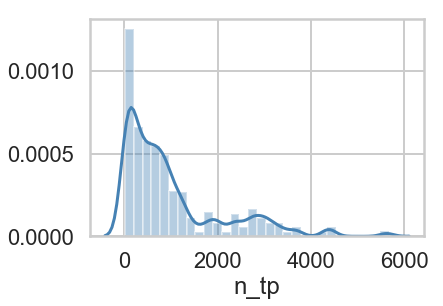

In [9]:
sns.distplot(net_data['n_tp'], bins=30, color='steelblue')

In [10]:
net_data.subj.nunique()

191

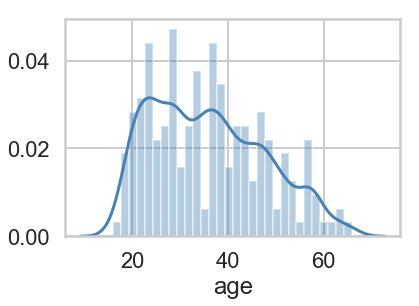

In [11]:
net_data['age'].replace(to_replace=0, value=None, inplace=True)
sns.distplot(net_data['age'].dropna(), bins=30, color='steelblue')
mean_age = net_data['age'].mean()

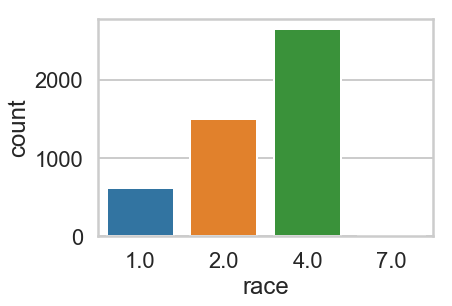

In [12]:
sns.countplot(data=net_data, x='race', )
mean_race = 4

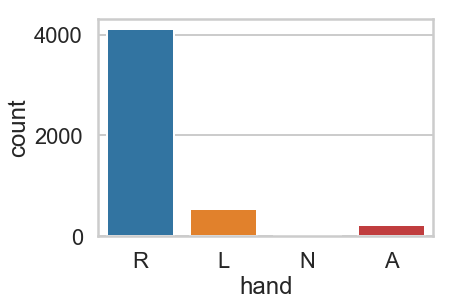

In [13]:
sns.countplot(data=net_data, x='hand', )
mean_hand = 'R'

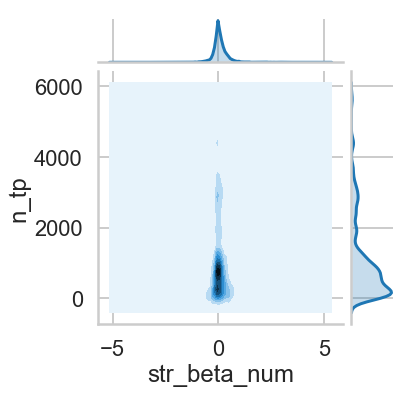

In [14]:
sns.jointplot(data=net_data, x='str_beta_num', y='n_tp', kind='kde' )

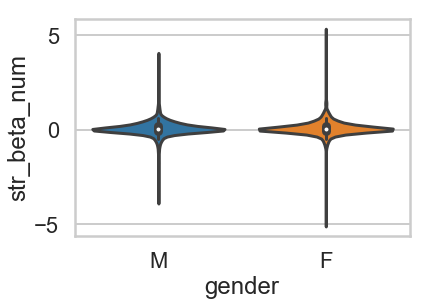

In [15]:
sns.violinplot(data=net_data, x='gender', y='str_beta_num', cut=True)

In [16]:
# add means for null values
net_data.loc[net_data['age'].isnull(), 'age'] = mean_age
net_data.loc[net_data['race'].isnull(), 'race'] = mean_race
net_data.loc[net_data['hand'].isnull(), 'hand'] = mean_hand

# same for node data
node_data.loc[node_data['age'].isnull(), 'age'] = mean_age
node_data.loc[node_data['race'].isnull(), 'race'] = mean_race
node_data.loc[node_data['hand'].isnull(), 'hand'] = mean_hand

In [17]:
# check for duplicates, these two numbers should match
print(net_data.dropna().subj.nunique())
print(net_data[net_data.band_measure == 'theta_plv'].dropna().subj.count())

119
119


In [18]:
# some subjects have ambidextrous and right handed answers in demographics, 
# take the one that is used in the net data (whatever they said first)
dems = ['race', 'hand', 'gender', 'age']
subjs = node_data['subj'].unique()
for s in subjs:
    if any(node_data.loc[node_data['subj'] == s, dems].nunique() > 1):
        correct_dems = net_data.loc[net_data.subj == s, dems]
        node_data.loc[node_data['subj'] == s, dems] = np.tile(correct_dems.iloc[0,:].values, 
                                                              (sum(node_data['subj'] == s),1))
node_data.drop(index=node_data.index[node_data.duplicated()], inplace=True)
node_data.dropna(axis=0).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192620 entries, 1 to 523568
Data columns (total 27 columns):
elec                      192620 non-null object
band_measure              192620 non-null object
n_tp                      192620 non-null int64
elec_spike                192620 non-null float64
elec_in_soz               192620 non-null int64
str_soz_beta_bin          192620 non-null float64
str_not_soz_beta_bin      192620 non-null float64
str_spike_beta_bin        192620 non-null float64
str_not_spike_beta_bin    192620 non-null float64
str_beta_bin              192620 non-null float64
str_soz_beta_num          192620 non-null float64
str_not_soz_beta_num      192620 non-null float64
str_spike_beta_num        192620 non-null float64
str_beta_num              192620 non-null float64
str_not_spike_beta_num    192620 non-null float64
fc_measure                192620 non-null object
band                      192620 non-null object
region                    192620 non-null objec

## Effects on Network Measures

visualize how much spikes regularly change network strength.

In [19]:
# save
# rename stuff to make it pretty
net_data.replace({'band':{'theta':'Theta', 'alpha':'Alpha','beta':'Beta', 'gamma':'Gamma',
                         'hg':'High Gamma', 'broadband':'LFP'}}, inplace=True)
net_data.rename(columns={'band':'Frequency Band', 'fc_measure':'Measure'}, inplace=True)
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_data_clean{detector}.csv')

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


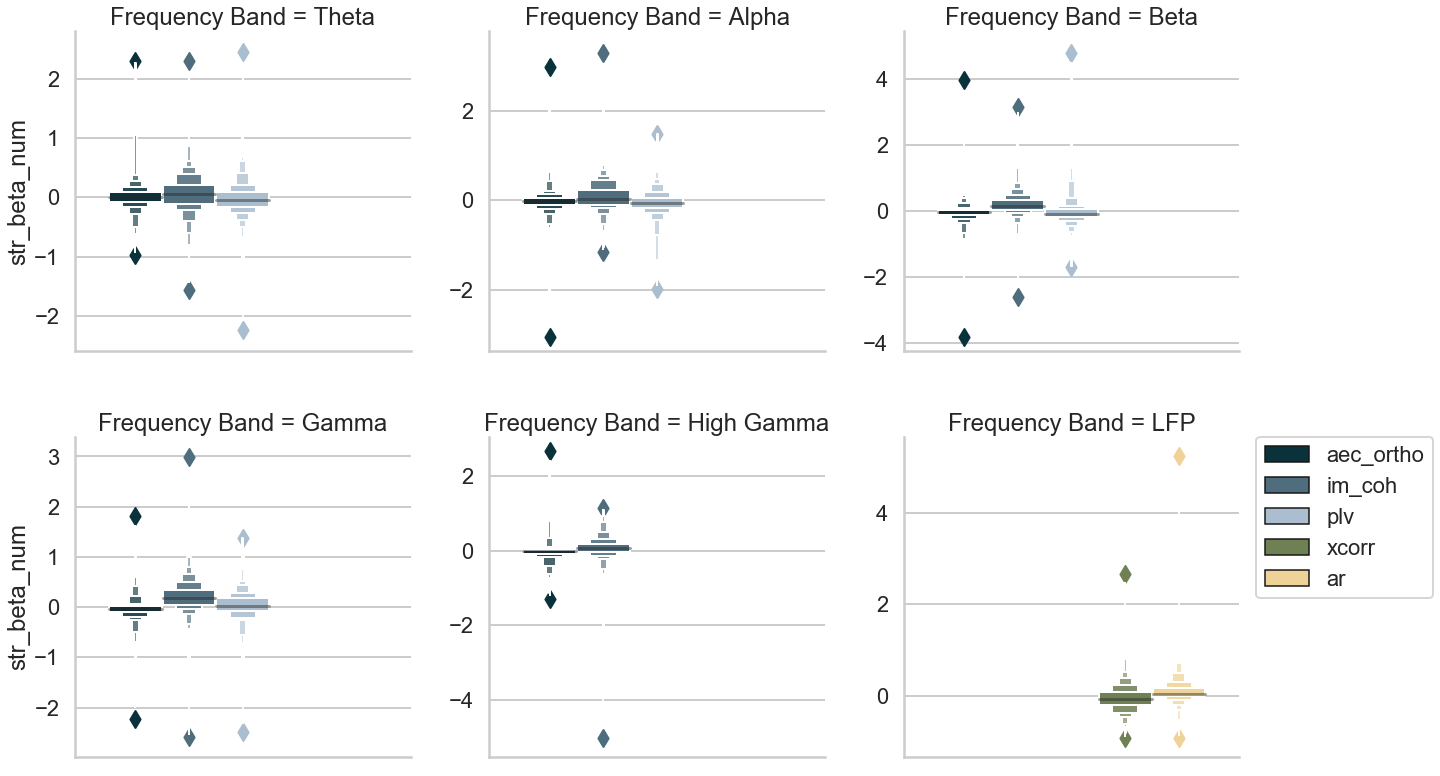

In [37]:
# parameters
supp_flag = True # if true, includes orthogonal AEC
yvar = 'num'

if (not supp_flag):
    h_order = ['aec', 'aec_ortho', 'coh', 'im_coh', 'plv', 'xcorr', 'ar']
    supp_ext = ''
    # colors
    colors = ['#453947', '#023743', '#84476f', '#476f84', '#A4BED5', '#72874E', '#FED789']
    custom_palette = sns.set_palette(sns.color_palette(colors))
else:
    h_order = ['aec_ortho', 'im_coh', 'plv', 'xcorr', 'ar']
    supp_ext = '_supp'
    # color pallette
    colors = ['#023743',  '#476f84', '#A4BED5', '#72874E', '#FED789']
    
# a different way of plotting where everything is on the same axis
#plt.figure(figsize=(20,10))
#sns.boxenplot( data=net_data, x="Frequency Band", y='str_beta_' + yvar, hue='Measure', 
#            order=['Theta','Alpha','Beta','Gamma','High Gamma','LFP'], hue_order=h_order)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


    
g = sns.FacetGrid(data=net_data, col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=6, 
                 col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'])
g.map(sns.boxenplot, 'Frequency Band', 'str_beta_' + yvar, 'Measure', palette = sns.color_palette(colors), 
      hue_order=h_order)

g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
for ax in g.axes:
    ax.axes.xaxis.set_visible(False)
    
g.savefig(f"../img/net_{yvar}_str{detector}.eps")



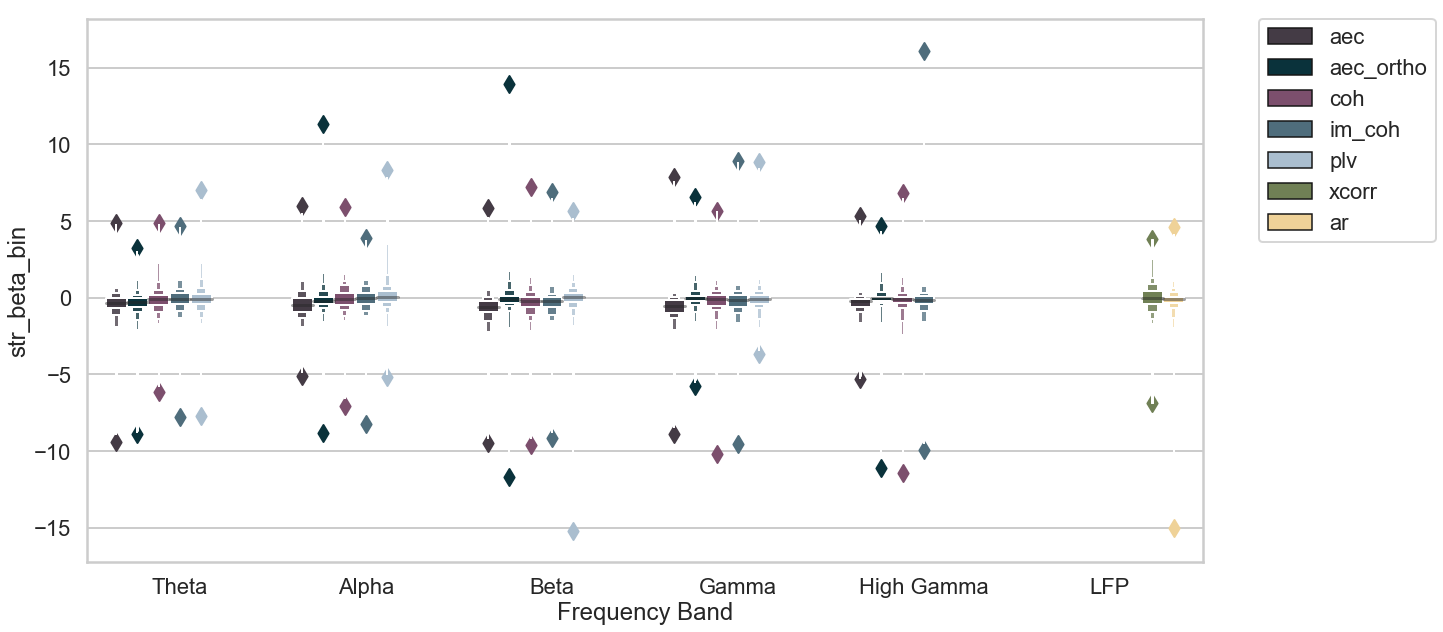

In [33]:
# parameters
supp_flag = False # if true, includes orthogonal AEC
yvar = 'bin'

if (not supp_flag):
    h_order = ['aec', 'aec_ortho', 'coh', 'im_coh', 'plv', 'xcorr', 'ar']
    supp_ext = ''
    # colors
    colors = ['#453947', '#023743', '#84476f', '#476f84', '#A4BED5', '#72874E', '#FED789']
    custom_palette = sns.set_palette(sns.color_palette(colors))
else:
    h_order = ['aec_ortho', 'im_coh', 'plv', 'xcorr', 'ar']
    supp_ext = '_supp'
    # color pallette
    colors = ['#023743',  '#476F84', '#A4BED5', '#72874E', '#FED789']
    custom_palette = sns.set_palette(sns.color_palette(colors))
    
# a different way of plotting where everything is on the same axis
plt.figure(figsize=(20,10))
sns.boxenplot( data=net_data, x="Frequency Band", y='str_beta_' + yvar, hue='Measure', 
            order=['Theta','Alpha','Beta','Gamma','High Gamma','LFP'], hue_order=h_order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.savefig(f"../img/net_{yvar}_str{detector}.png")



Is this because of volume conduction?

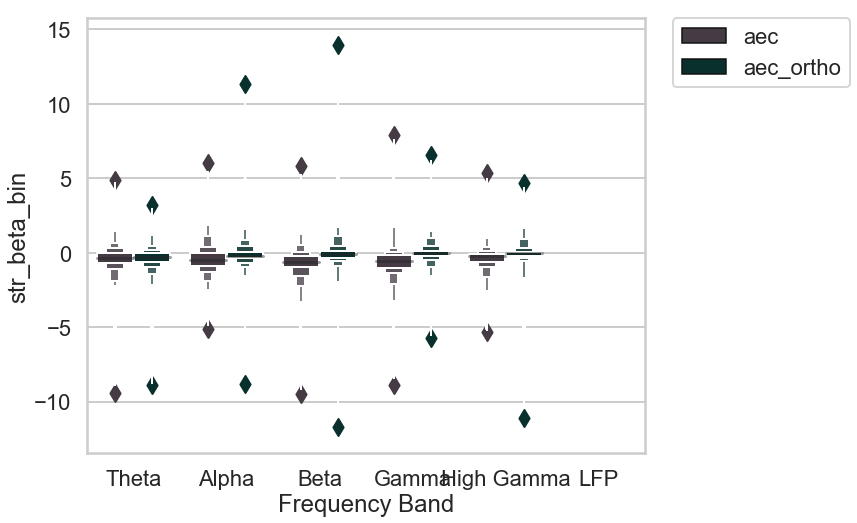

In [47]:

# parameters
y_var = 'bin'
m = 'aec'

if (m == 'coh'):
    h_order = ['coh', 'im_coh']
    # color pallette
    colors = ['#84476f', '#476f84']
else:
    h_order = ['aec', 'aec_ortho']
    colors = ['#453947', '#023732']
custom_palette = sns.set_palette(sns.color_palette(colors))

fig = plt.figure(figsize=(10,8))
sns.boxenplot( data=net_data[(net_data['Measure'] == h_order[0]) | (net_data['Measure'] == h_order[1])]
              , x="Frequency Band", y='str_beta_' + y_var, hue='Measure', 
            order=['Theta','Alpha','Beta','Gamma','High Gamma','LFP'], hue_order=h_order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.ylim(-2,2)
plt.savefig(f"../img/volume_conduction_{y_var}_{m}{detector}.eps")


Is it different within or outside of the SOZ?

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


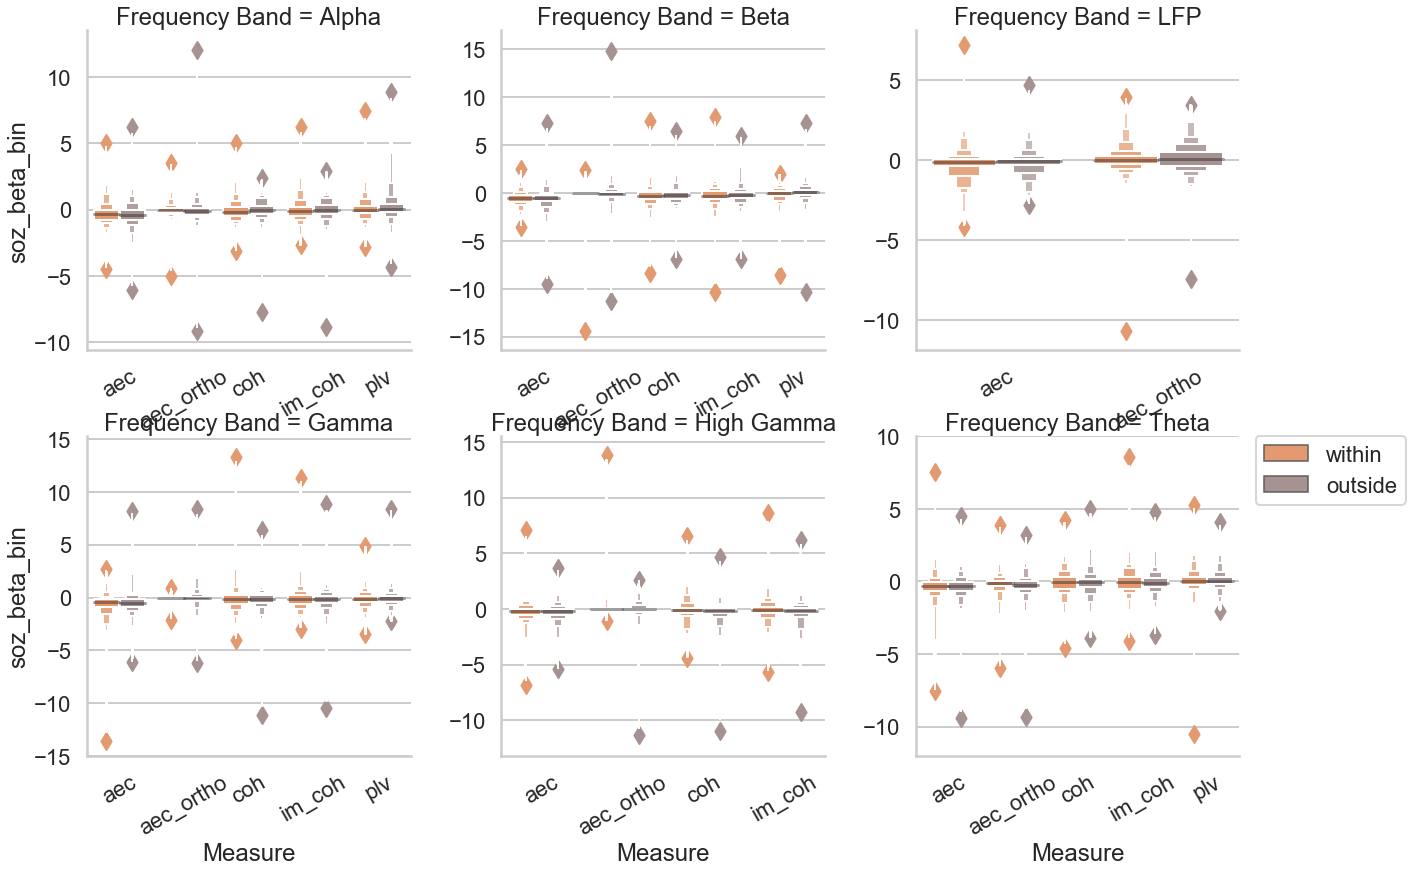

In [53]:
yvar = 'bin'

# reshape data
soz_data = pd.melt(net_data, id_vars =['Frequency Band', 'Measure', 'subj', 'hand','race','gender','age'], 
                           value_vars =['str_soz_beta_' + yvar,'str_not_soz_beta_' + yvar],  
                           var_name ='SOZ', value_name ='soz_beta_' + yvar)  
soz_data['SOZ'].replace(['str_soz_beta_' + yvar, 'str_not_soz_beta_' + yvar], ['within', 'outside'], inplace=True)
#color pallette
colors = ['#F6955E', '#A98F8E']
    
g = sns.FacetGrid(data=soz_data, col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=6, )
g.map(sns.boxenplot, 'Measure', 'soz_beta_' + yvar, 'SOZ', palette = sns.color_palette(colors), 
      hue_order=['within','outside'])
for a in g.axes:
    a.set_xticklabels(g.axes[0].xaxis.get_majorticklabels(),rotation=30)

g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
    

if yvar == 'num':
    soz_num = soz_data
else:
    soz_bin = soz_data


In [49]:
# add difference for plotting
net_data = net_data.assign(soz_diff_num = net_data['str_soz_beta_num'] - net_data['str_not_soz_beta_num'], 
                           soz_diff_bin = net_data['str_soz_beta_bin'] - net_data['str_not_soz_beta_bin'])

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


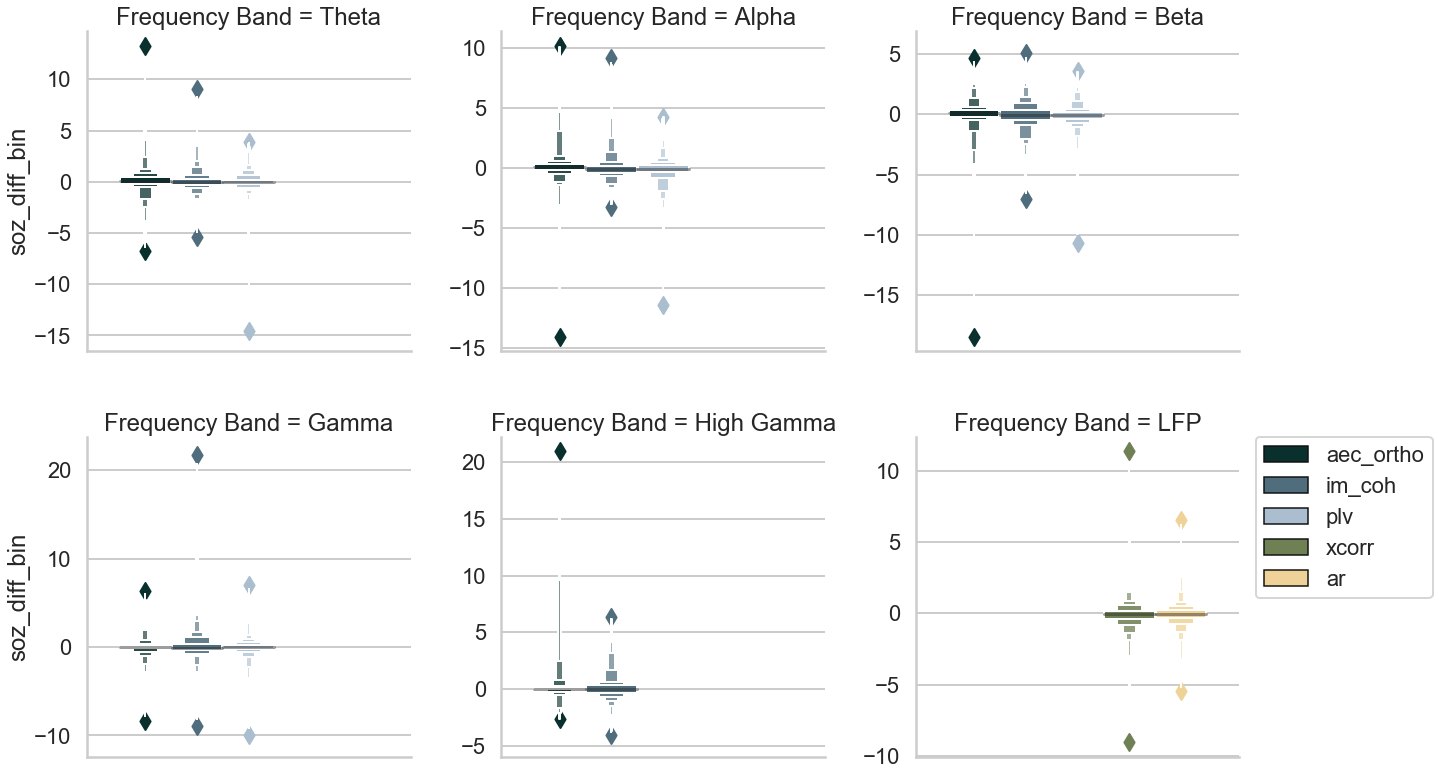

In [51]:
yvar = 'bin'

colors = ['#023732', '#476f84', '#a4bed5', '#72874e', '#fed789']
h_order = ['aec_ortho', 'im_coh', 'plv', 'xcorr', 'ar']

g = sns.FacetGrid(data=net_data, col='Frequency Band', col_wrap=3, sharex=False, sharey=False, height=6,
                 col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'])
g.map(sns.boxenplot, "Frequency Band", "soz_diff_" + yvar, "Measure",
             hue_order = h_order,  palette=sns.color_palette(colors))
g.axes[5].legend(bbox_to_anchor=(1.05,1), loc=2,borderaxespad=0.)
for ax in g.axes:
    ax.axes.xaxis.set_visible(False)

g.savefig(f"../img/net_soz_{yvar}{detector}.eps")

In [54]:
# save
soz_net_data = pd.merge(soz_bin, soz_num, on=['Frequency Band', 'Measure', 'subj', 'SOZ', 'hand','race','gender','age'])
soz_net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_soz_data_clean{detector}.csv')

Repeat for spikes

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


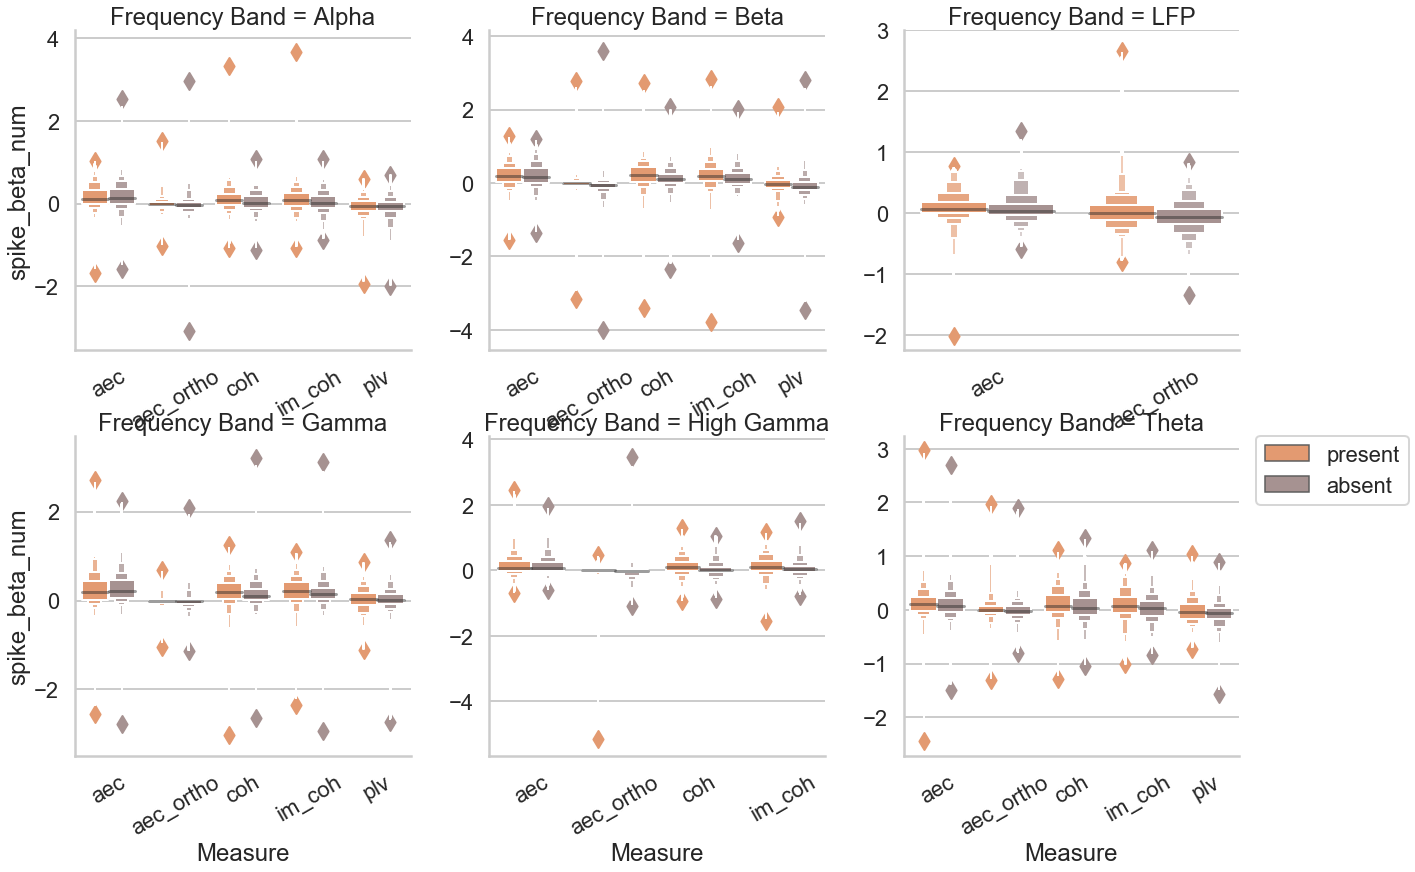

In [56]:
yvar = 'num'

# reshape data
spike_data = pd.melt(net_data, id_vars =['Frequency Band', 'Measure', 'subj', 'hand','race','gender','age'], 
                           value_vars =['str_spike_beta_' + yvar,'str_not_spike_beta_' + yvar],  
                           var_name ='spike', value_name ='spike_beta_' + yvar)  
spike_data['spike'].replace(['str_spike_beta_' + yvar, 'str_not_spike_beta_' + yvar], ['present', 'absent'], inplace=True)
#color pallette
colors = ['#F6955E', '#A98F8E']
    
g = sns.FacetGrid(data=spike_data, col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=6, )
g.map(sns.boxenplot, 'Measure', 'spike_beta_' + yvar, 'spike', palette = sns.color_palette(colors), 
      hue_order=['present','absent'])
for a in g.axes:
    a.set_xticklabels(g.axes[0].xaxis.get_majorticklabels(),rotation=30)

g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
    
if yvar == 'num':
    spike_num = spike_data
else:
    spike_bin = spike_data


In [57]:
# add difference for plotting
net_data = net_data.assign(spike_diff_num = net_data['str_spike_beta_num'] - net_data['str_not_spike_beta_num'], 
                           spike_diff_bin = net_data['str_spike_beta_bin'] - net_data['str_not_spike_beta_bin'])

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


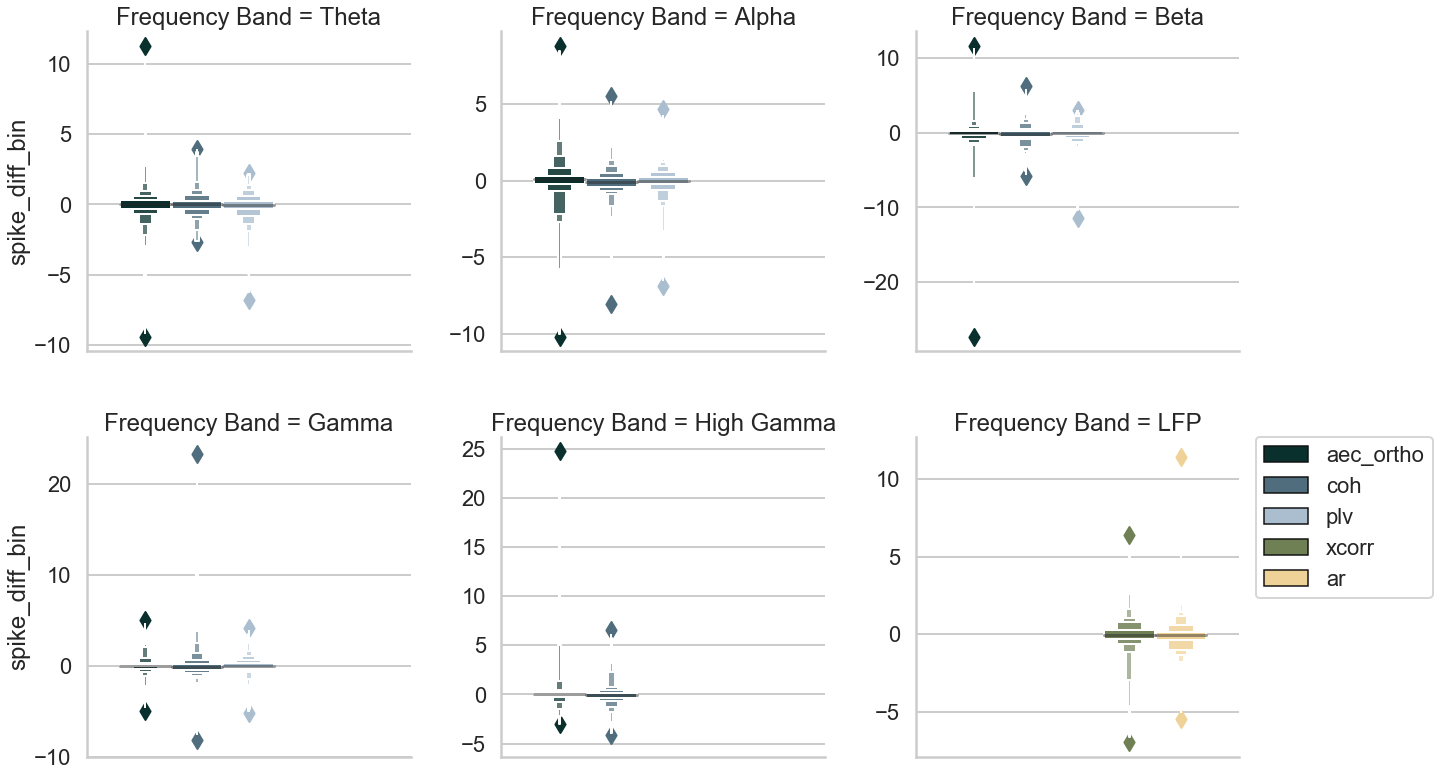

In [60]:
yvar = 'bin'

colors = ['#023732', '#476f84', '#a4bed5', '#72874e', '#fed789']
h_order = ['aec_ortho', 'coh', 'plv', 'xcorr', 'ar']

g=sns.FacetGrid(data=net_data, col="Frequency Band", col_wrap=3, col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'],
                sharex=False, sharey=False, height=6)
g.map(sns.boxenplot, "Frequency Band", "spike_diff_" + yvar, "Measure",
             hue_order = h_order, palette=sns.color_palette(colors))
g.axes[5].legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)
for a in g.axes:
    a.axes.xaxis.set_visible(False)
g.savefig(f"../img/net_spike_{yvar}{detector}.eps")

In [61]:
# save
spike_net_data = pd.merge(spike_bin, spike_num, on=['Frequency Band', 'Measure', 'subj', 'spike', 'hand','race','gender','age'])
spike_net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_spike_data_clean{detector}.csv')

## Which explains more variance? Coverage, or individual?

In [62]:
# get correlation matrix for all str effects
# thi subj has duplicates...unclear why
node_data = node_data[node_data['subj'] != 'R1232N']
sim_data = node_data[['subj', 'region', 'str_beta_bin', 'str_beta_num', 'band_measure']]
sim_data = sim_data.assign(unique_id = sim_data['subj'] + '_' + sim_data['region'], 
                           reg_id = sim_data['region'] + '_' + sim_data['subj'])
subj_data = sim_data.pivot_table(index = 'unique_id', columns='band_measure', 
                          values = ['str_beta_bin', 'str_beta_num']) # default agg func is mean
subj_data.head()

str_beta_bin                                         \
band_measure               alpha_aec alpha_aec_ortho alpha_coh alpha_im_coh   
unique_id                                                                     
R1001P_fusiform             0.047989       -0.001969  0.116477     0.107440   
R1001P_inferiortemporal    -0.117190       -0.006814  0.084597     0.066514   
R1001P_lateraloccipital    -0.193000       -0.004700  0.236389     0.236432   
R1001P_lingual             -0.076008       -0.003474  0.162889     0.174597   
R1001P_middletemporal      -0.174446        0.002243  0.065737     0.032634   

                                                                      \
band_measure            alpha_plv  beta_aec beta_aec_ortho  beta_coh   
unique_id                                                              
R1001P_fusiform          0.064843 -0.213095       0.000302 -0.032015   
R1001P_inferiortemporal -0.041423 -0.172614      -0.001548  0.128849   
R1001P_lateraloccipital  0.104319 -0.328138      -0.001752  0.059280   
R1001P_lingual           0.049067 -0.128282       0.000470  0.235316   
R1001P_middletemporal    0.069563 -0.108570      -0.001329 -0.106800   

                                                 ...    str_beta_num  \
band_measure            beta_im_coh  beta_plv    ...       gamma_plv   
unique_id                                        ...                   
R1001P_fusiform           -0.050964 -0.020874    ...       -0.005028   
R1001P_inferiortemporal    0.138102  0.052919    ...       -0.014448   
R1001P_lateraloccipital    0.050693  0.084547    ...        0.008394   
R1001P_lingual             0.236976  0.113932    ...       -0.010294   
R1001P_middletemporal     -0.111112  0.091273    ...        0.029377   

                                                                              \
band_measure               hg_aec hg_aec_ortho    hg_coh hg_im_coh theta_aec   
unique_id                                                                      
R1001P_fusiform          0.009761    -0.000009 -0.005795 -0.013038  0.042193   
R1001P_inferiortemporal  0.012741    -0.000014  0.030200  0.049418  0.014487   
R1001P_lateraloccipital  0.013173    -0.000025  0.009163  0.031252  0.005682   
R1001P_lingual          -0.034190     0.000018  0.050679  0.068310 -0.006008   
R1001P_middletemporal    0.017861     0.000015  0.016850  0.017947 -0.000289   

                                                                          
band_measure            theta_aec_ortho theta_coh theta_im_coh theta_plv  
unique_id                                                                 
R1001P_fusiform               -0.003326  0.002174    -0.002646  0.003716  
R1001P_inferiortemporal       -0.013538  0.007185     0.012087 -0.042675  
R1001P_lateraloccipital        0.007567 -0.015855    -0.014484 -0.001712  
R1001P_lingual                 0.011250  0.051744     0.041703  0.000200  
R1001P_middletemporal          0.001982  0.041262     0.045299  0.003767  

[5 rows x 52 columns]

In [63]:
# get correlation matrix for all str effects
reg_data = sim_data.pivot_table(index = 'reg_id', columns='band_measure', 
                          values = ['str_beta_bin', 'str_beta_num']) # default agg func is mean
reg_data.head()

str_beta_bin                                                   \
band_measure       alpha_aec alpha_aec_ortho alpha_coh alpha_im_coh alpha_plv   
reg_id                                                                          
bankssts_R1008J    -0.605947        0.006764 -0.550321    -0.587617 -0.137149   
bankssts_R1009W    -0.871009        0.007601  0.375139     0.626480 -0.196495   
bankssts_R1014D     0.432329        0.009630  1.289233     1.163059  0.287680   
bankssts_R1015J    -0.029998        0.020272  0.146794     0.104230  0.201222   
bankssts_R1018P    -1.980115        0.210688  1.793185     2.873314  2.663156   

                                                                          \
band_measure     beta_aec beta_aec_ortho  beta_coh beta_im_coh  beta_plv   
reg_id                                                                     
bankssts_R1008J -0.541359      -0.003079 -0.231815   -0.268487 -0.073163   
bankssts_R1009W  0.633843      -0.002712  0.608152    0.050491  1.032841   
bankssts_R1014D  0.388816       0.013649 -0.205244   -0.121215 -0.196499   
bankssts_R1015J -0.111912      -0.000479  0.002277   -0.041211  0.211442   
bankssts_R1018P  0.578112       0.022915  0.625316    1.076158 -1.251089   

                   ...    str_beta_num                                   \
band_measure       ...       gamma_plv    hg_aec hg_aec_ortho    hg_coh   
reg_id             ...                                                    
bankssts_R1008J    ...        0.148545 -0.081021    -0.000273  0.152299   
bankssts_R1009W    ...        0.022510  0.232758    -0.002164  0.058050   
bankssts_R1014D    ...        0.352863  0.249345     0.000206 -0.170699   
bankssts_R1015J    ...       -0.016858  0.025231    -0.000193  0.064840   
bankssts_R1018P    ...       -0.231588 -0.008354    -0.000002 -0.057513   

                                                                            \
band_measure    hg_im_coh theta_aec theta_aec_ortho theta_coh theta_im_coh   
reg_id                                                                       
bankssts_R1008J  0.227692  0.091772        0.067263  0.259752     0.223983   
bankssts_R1009W -0.008001  0.323400       -0.010346  0.394888     0.329903   
bankssts_R1014D -0.110897  0.269739        0.013703 -0.404718    -0.415142   
bankssts_R1015J  0.093011  0.036269       -0.035951  0.074575     0.073611   
bankssts_R1018P -0.063427  0.141113        0.034036  0.103033     0.141809   

                           
band_measure    theta_plv  
reg_id                     
bankssts_R1008J -0.007283  
bankssts_R1009W -0.027110  
bankssts_R1014D -0.068376  
bankssts_R1015J -0.095429  
bankssts_R1018P  0.079300  

[5 rows x 52 columns]

In [64]:
# ordered by subj corr map
sim_metric = 'corr' # correlation or euclidean distance
if sim_metric == 'corr':
    rsm = subj_data.T.corr()
    reg_rsm = reg_data.T.corr()
else:
    rsm = euclidean_distances(subj_data)
    reg_rsm = euclidean_distances(reg_data)

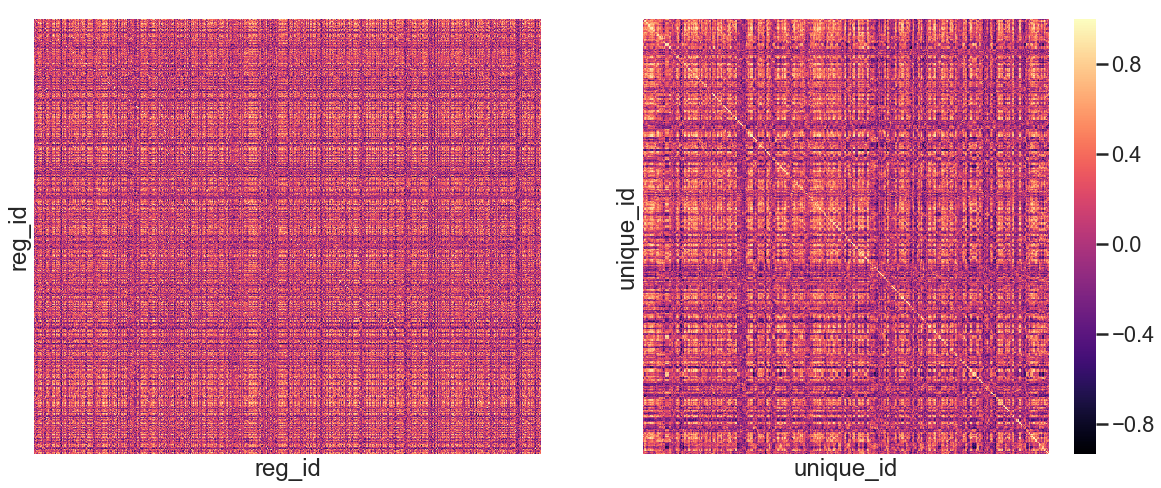

In [70]:
fig, axes = plt.subplots(1,2, figsize=(20,8))
sns.heatmap(reg_rsm, xticklabels=False, yticklabels=False, cmap = 'magma',  cbar=False, ax=axes[0])
sns.heatmap(rsm, xticklabels=False, yticklabels=False, cmap='magma', cbar=True, ax=axes[1])

In [71]:
# get distributions for each group
subj_corrs = []
btwn_subj = []
reg_corrs = []
btwn_reg = []
label = []
for s in sim_data.subj.unique():
    idx = subj_data.index.str.contains(s)
    if sim_metric == 'corr':
        curr = rsm.values[:,idx]
    else:
        curr = rsm[:,idx]
    btwn_curr = curr[~idx,:]
    curr = curr[idx,:]
    subj_corrs.append(np.nanmean(curr))
    btwn_subj.append(np.nanmean(btwn_curr))
    label.append('subj')
    
for r in sim_data.region.unique():
        idx = reg_data.index.str.contains(str(r))
        if sum(idx) > 0:
            if sim_metric == 'corr':
                curr = reg_rsm.values[:,idx]
            else:
                curr = reg_rsm[:,idx]
            btwn_curr = curr[~idx,:]
            curr = curr[idx,:]
            reg_corrs.append(np.nanmean(curr))
            btwn_reg.append(np.nanmean(btwn_curr))
            label.append('region')
            
subj_corrs.extend(reg_corrs)
btwn_subj.extend(btwn_reg)

/Users/stiso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/Users/stiso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


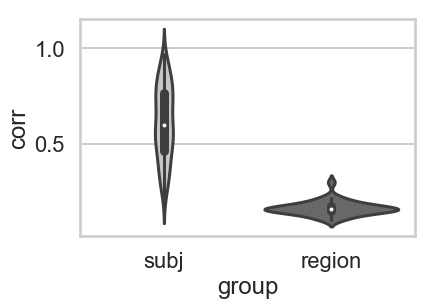

In [72]:
group_sim = pd.DataFrame({'corr':subj_corrs, 'btwn_corr':btwn_subj, 'group':label })
colors = ['#F6955E', '#A98F8E']
sns.violinplot(data=group_sim, x='group', y='corr', palette = 'Greys')
plt.savefig(f"../img/group_var{detector}.pdf")

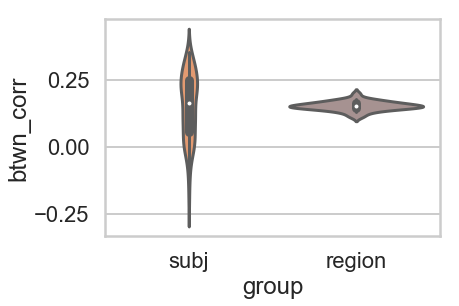

In [73]:
sns.violinplot(data=group_sim, x='group', y='btwn_corr', palette=sns.set_palette(colors))

In [74]:
group_sim.groupby('group').describe()

btwn_corr                                                              \
           count      mean       std       min       25%       50%       75%   
group                                                                          
region      34.0  0.153512  0.017100  0.113036  0.146351  0.151391  0.163210   
subj       184.0  0.152128  0.122268 -0.211464  0.054921  0.165992  0.249565   

                   corr                                                    \
             max  count      mean       std       min       25%       50%   
group                                                                       
region  0.198653   34.0  0.162786  0.036581  0.102608  0.145759  0.156287   
subj    0.355871  184.0  0.612097  0.189991  0.217185  0.461395  0.600722   

                            
             75%       max  
group                       
region  0.175474  0.298336  
subj    0.767702  0.969553

## Effects on Node Measures

relationship between the number of spikes seen in that node, and the beta value

/Users/stiso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


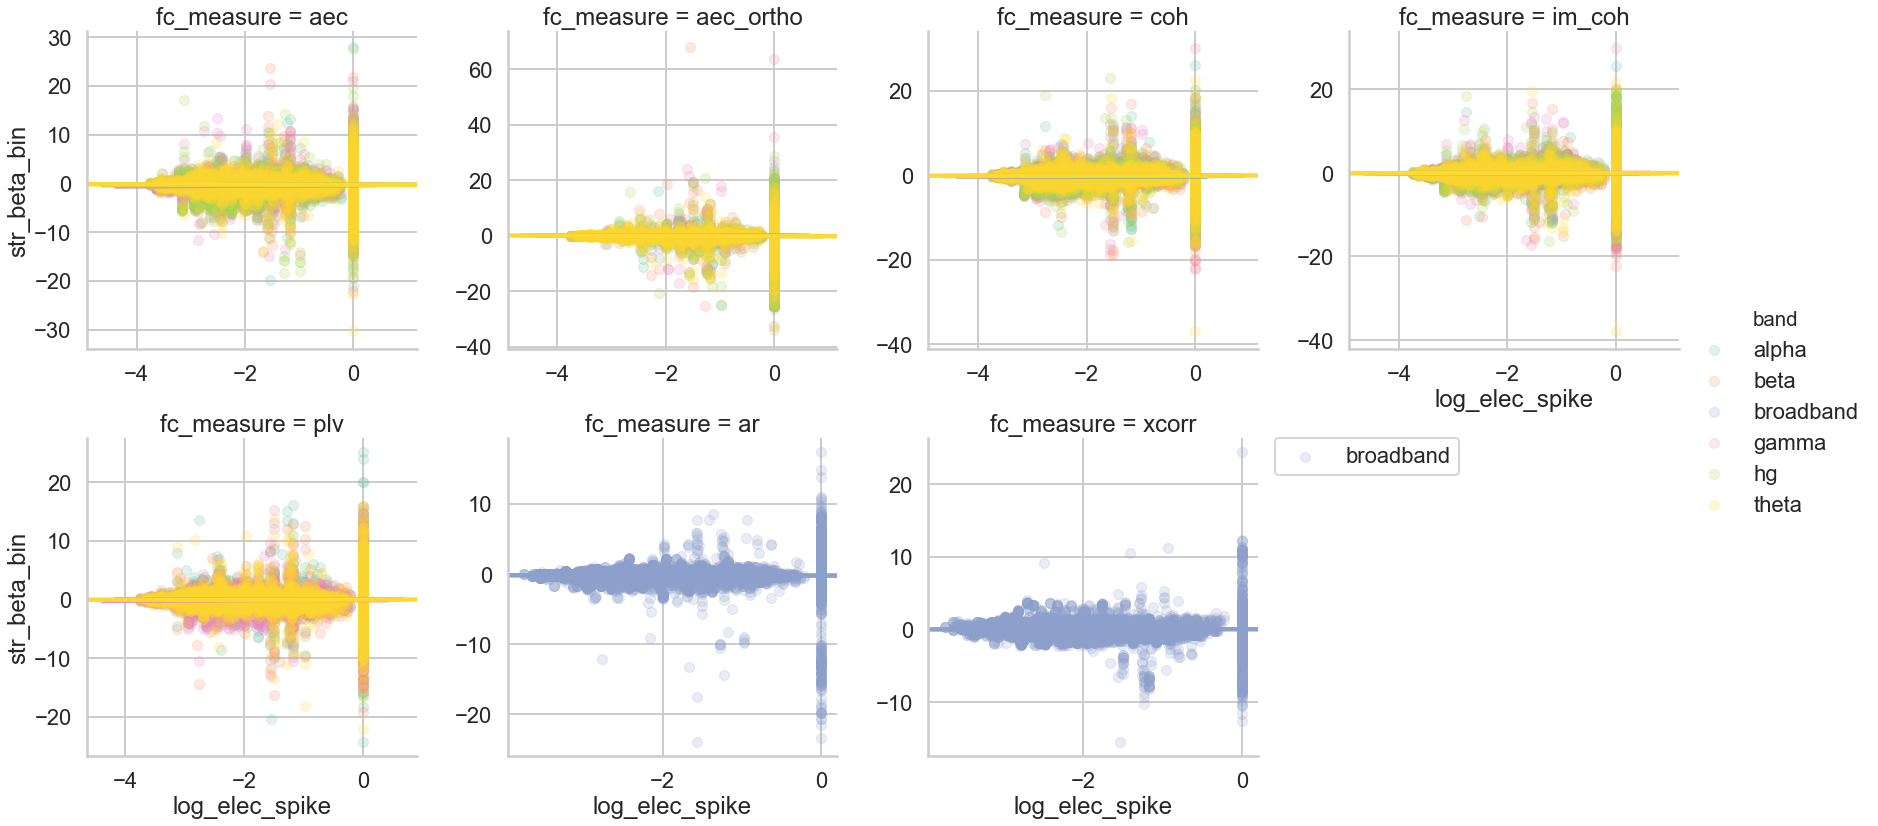

In [75]:
# add log transform
log_spike = np.zeros(np.shape(node_data['elec_spike']))
log_spike[[node_data['elec_spike'] != 0]] = np.log10(node_data['elec_spike'][node_data['elec_spike'] != 0])
node_data['log_elec_spike'] = log_spike

#color pallette
colors = ['#5b6c88', '#f0eee2']
custom_palette = sns.set_palette('Set2')

#plt.figure(figsize=(40,20))
sns.lmplot(data=node_data, x='log_elec_spike', y='str_beta_bin', hue='band', col="fc_measure", 
           col_wrap=4, height=6, sharex=False, sharey=False, scatter_kws={'s':100, 'alpha':.2})

plt.legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
#for ax in g.axes:
#    ax.set_ylim(-2,2)
    

Total strength by type

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


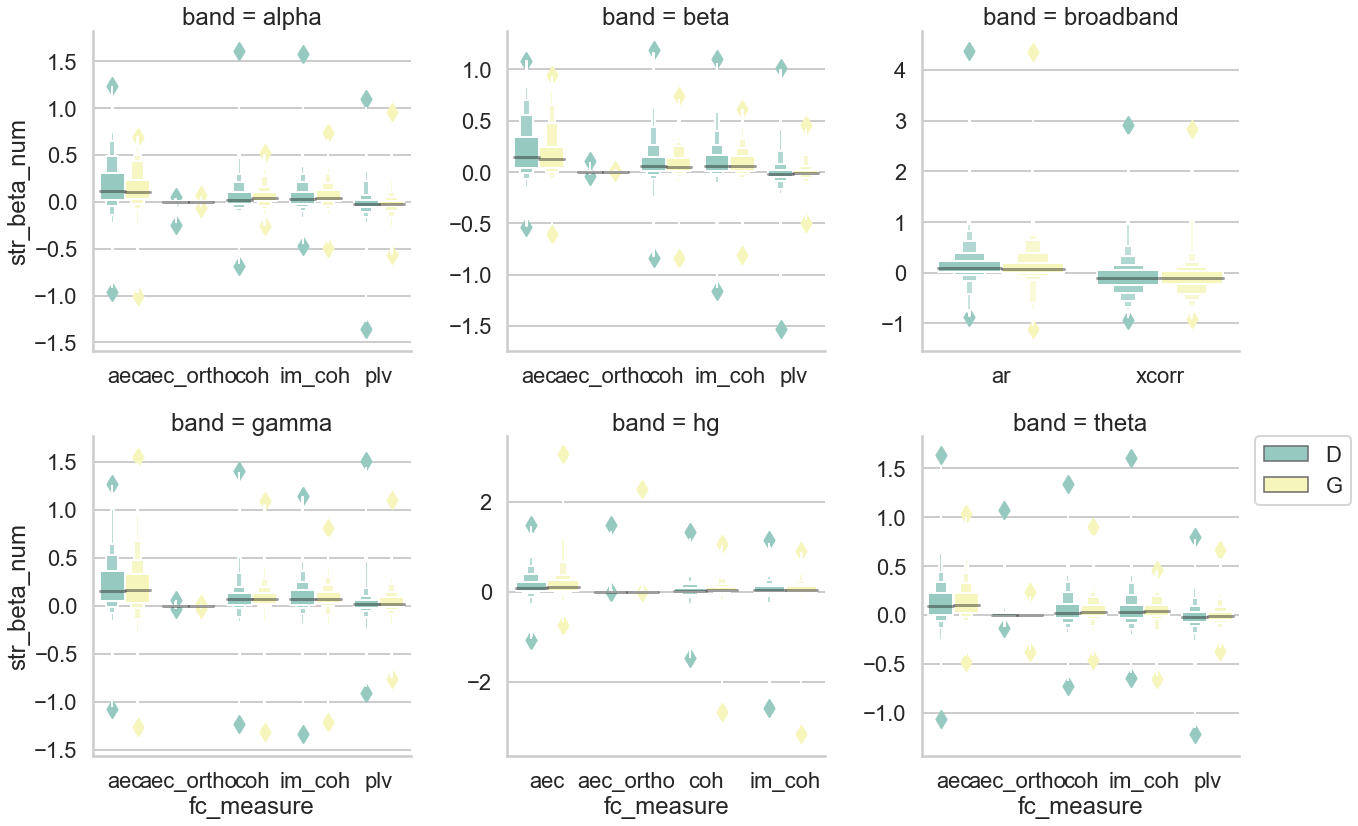

In [76]:
# strip is functionally the same as grid
node_data.loc[node_data.type == 'S','type'] = 'G'
type_avg = node_data.groupby(['subj', 'band', 'fc_measure', 'type']).median().reset_index()

# grand teton natl park color pallette
colors = ['#a8d0cf', '#babbb1']
custom_palette = sns.set_palette(sns.color_palette(colors))
    
g = sns.FacetGrid(data=type_avg, col='band', col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, size=6)
g.map(sns.boxenplot, 'fc_measure', 'str_beta_num', 'type', palette = 'Set3', hue_order = ['D','G'])

g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
type_avg.to_csv(f'{RAM_dir}group_analysis/win_{win}/type_stats{detector}.csv')

In [77]:
# load system data
sys = pd.read_csv(f'{RAM_dir}group_analysis/win_{win}/contact_sys{detector}.csv', index_col=0)


In [78]:
# check number of contacts
# contacts that are really far away end up labelled as vis
sys['sys'].value_counts()

Vis            97140
Default         4647
Limbic          2391
SalVentAttn     1940
SomMot          1597
Cont            1416
DorsAttn        1320
Name: sys, dtype: int64

In [79]:
sys.groupby(['subj','sys']).min_d.mean().head(25)

subj    sys        
R1001P  Cont            13.462925
        Default         16.000491
        DorsAttn        12.306150
        Limbic          20.120398
        SalVentAttn     15.065420
        SomMot          13.164589
        Vis             14.353137
R1002P  Cont            14.499693
        Default         20.114818
        DorsAttn        16.196721
        Limbic          19.731470
        SalVentAttn     19.326486
        SomMot          13.525720
        Vis             16.885360
R1003P  Vis                   NaN
R1004D  Cont           120.370063
        Default        153.841812
        SalVentAttn    128.240812
R1006P  Vis                   NaN
R1008J  Default         15.089609
        DorsAttn        16.060019
        Limbic          16.926507
        SalVentAttn     16.998840
        Vis             15.265479
R1009W  Vis                   NaN
Name: min_d, dtype: float64

In [80]:
# merge
node_data = pd.merge(node_data, sys, on=['subj', 'elec', 'region', 'x' ,'y', 'z', 'race', 
                                         'hand', 'gender', 'type', 'age'])
node_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2407340 entries, 0 to 2407339
Data columns (total 32 columns):
elec                      object
band_measure              object
n_tp                      int64
elec_spike                float64
elec_in_soz               int64
str_soz_beta_bin          float64
str_not_soz_beta_bin      float64
str_spike_beta_bin        float64
str_not_spike_beta_bin    float64
str_beta_bin              float64
str_soz_beta_num          float64
str_not_soz_beta_num      float64
str_spike_beta_num        float64
str_beta_num              float64
str_not_spike_beta_num    float64
fc_measure                object
band                      object
region                    object
x                         float64
y                         float64
z                         float64
type                      object
subj                      object
hand                      object
age                       float64
gender                    object
race            

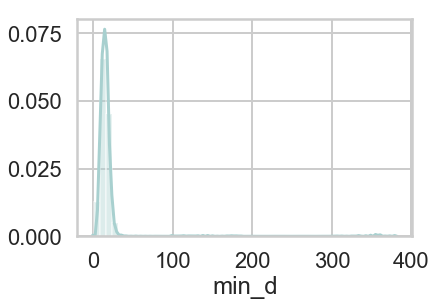

In [81]:
# how well are the MNI coordinates doing? Are centroids usually close?
sns.distplot(node_data['min_d'].dropna())

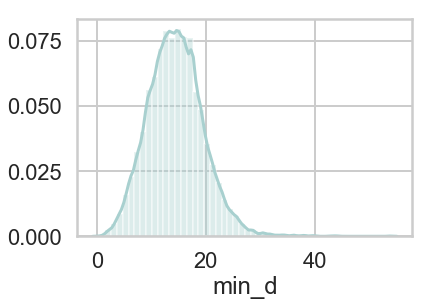

In [82]:
# get reid of contacts that clearly had poor match - greater than 2 std
node_data.loc[node_data['min_d'] > node_data['min_d'].mean() + node_data['min_d'].std(),['sys', 'parc', 'min_d', 'region']] = np.nan
sns.distplot(node_data['min_d'].dropna())

In [83]:
# get region -> system mapping to see if the MNI labels are any good
node_data.dropna(inplace=True, axis=0, subset=['min_d'])
reg_sys_map = node_data.groupby(['subj', 'elec'])[['region','sys']].head()
reg_sys_map.to_csv(f'{RAM_dir}group_analysis/win_{win}/reg_sys_map{detector}.csv')
reg_sys_map.head()


region      sys
0  inferiorparietal  Default
1  inferiorparietal  Default
2  inferiorparietal  Default
3  inferiorparietal  Default
4  inferiorparietal  Default

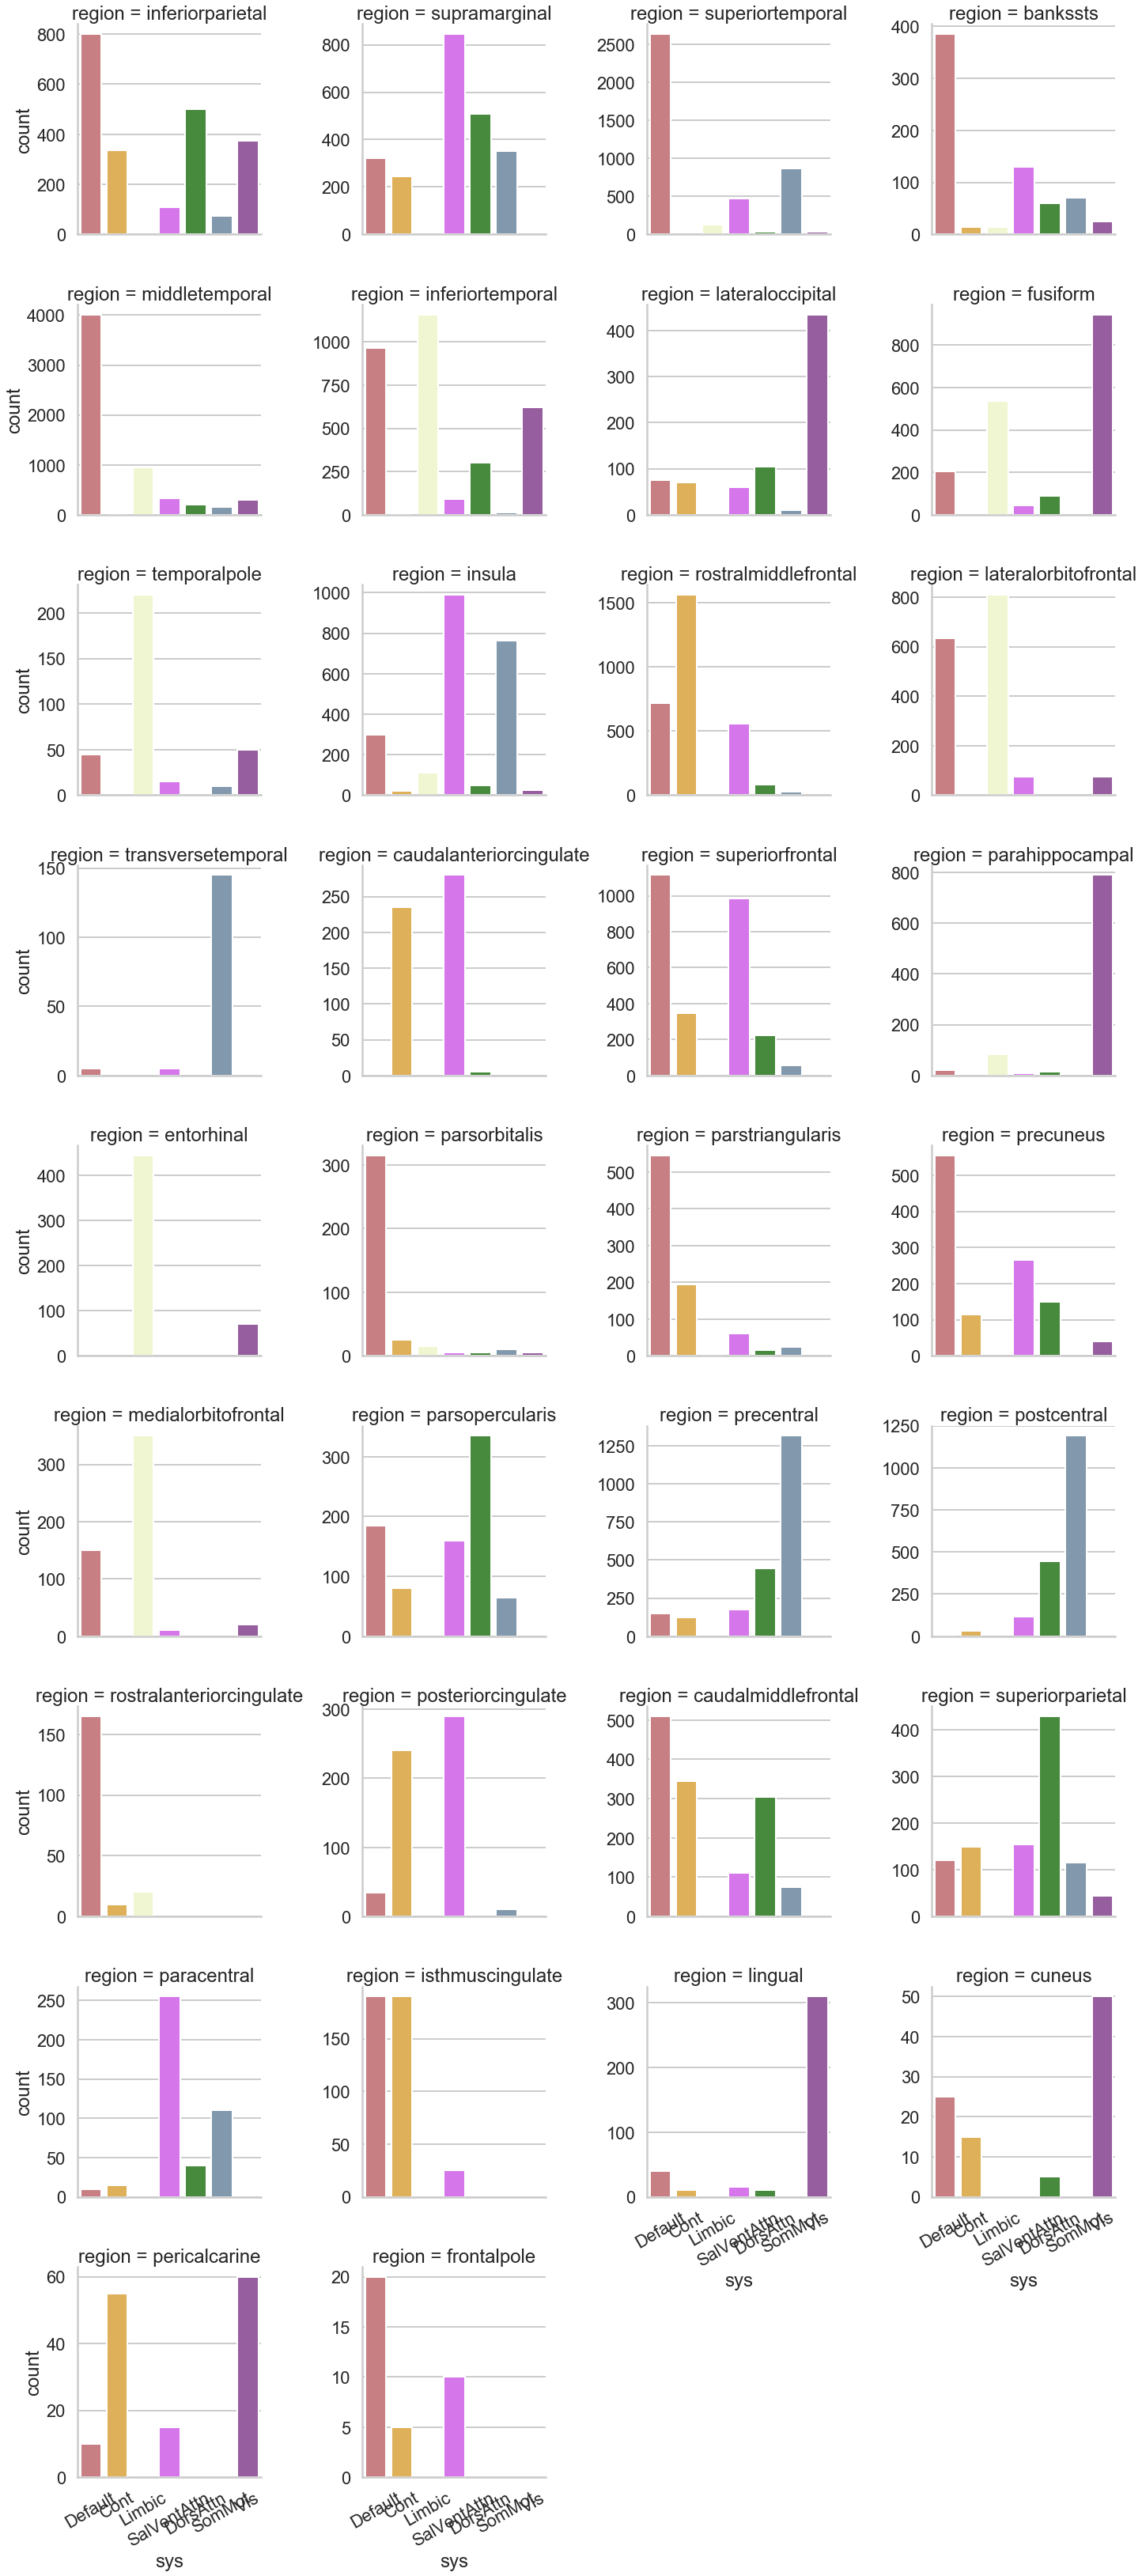

In [84]:
sys_colors = ['#d37379', '#f3b743', '#f5fccc', '#e164fe', '#3e9730', '#7b98b3', '#9f53aa']
sys_pal = sns.color_palette(sys_colors)
p = sns.catplot(data=reg_sys_map, x='sys', col='region', kind='count', col_wrap=4, sharey=False,
           order = ['Default', 'Cont', 'Limbic', 'SalVentAttn', 'DorsAttn', 'SomMot', 'Vis'],
           palette=sys_pal)
for a in p.axes:
    a.set_xticklabels(a.xaxis.get_majorticklabels(), rotation=30)
p.savefig(f'{RAM_dir}img/MNI_labels.png')

In [85]:
# z-score within subject
#node_data.drop(['scale_num', 'scale_bin'], axis=1, inplace=True) # comment this out if defining scaled vars for the first time
node_data.insert(5, 'scale_num', node_data.groupby(['subj', 'band_measure'])['str_beta_num'].transform(
    lambda x: sp.stats.zscore(x)))
node_data.insert(5, 'scale_bin', node_data.groupby(['subj', 'band_measure'])['str_beta_bin'].transform(
    lambda x: sp.stats.zscore(x)))
# average over systems, so every subj has 1 pt per sys (if they had coverage there)
sys_avg = node_data.groupby(['subj', 'band', 'fc_measure', 'sys'])['scale_num', 'scale_bin'].median().reset_index()
sys_avg.head()
sys_avg.to_csv(f'{RAM_dir}group_analysis/win_{win}/sys_stats.csv')

/Users/stiso/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2315: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


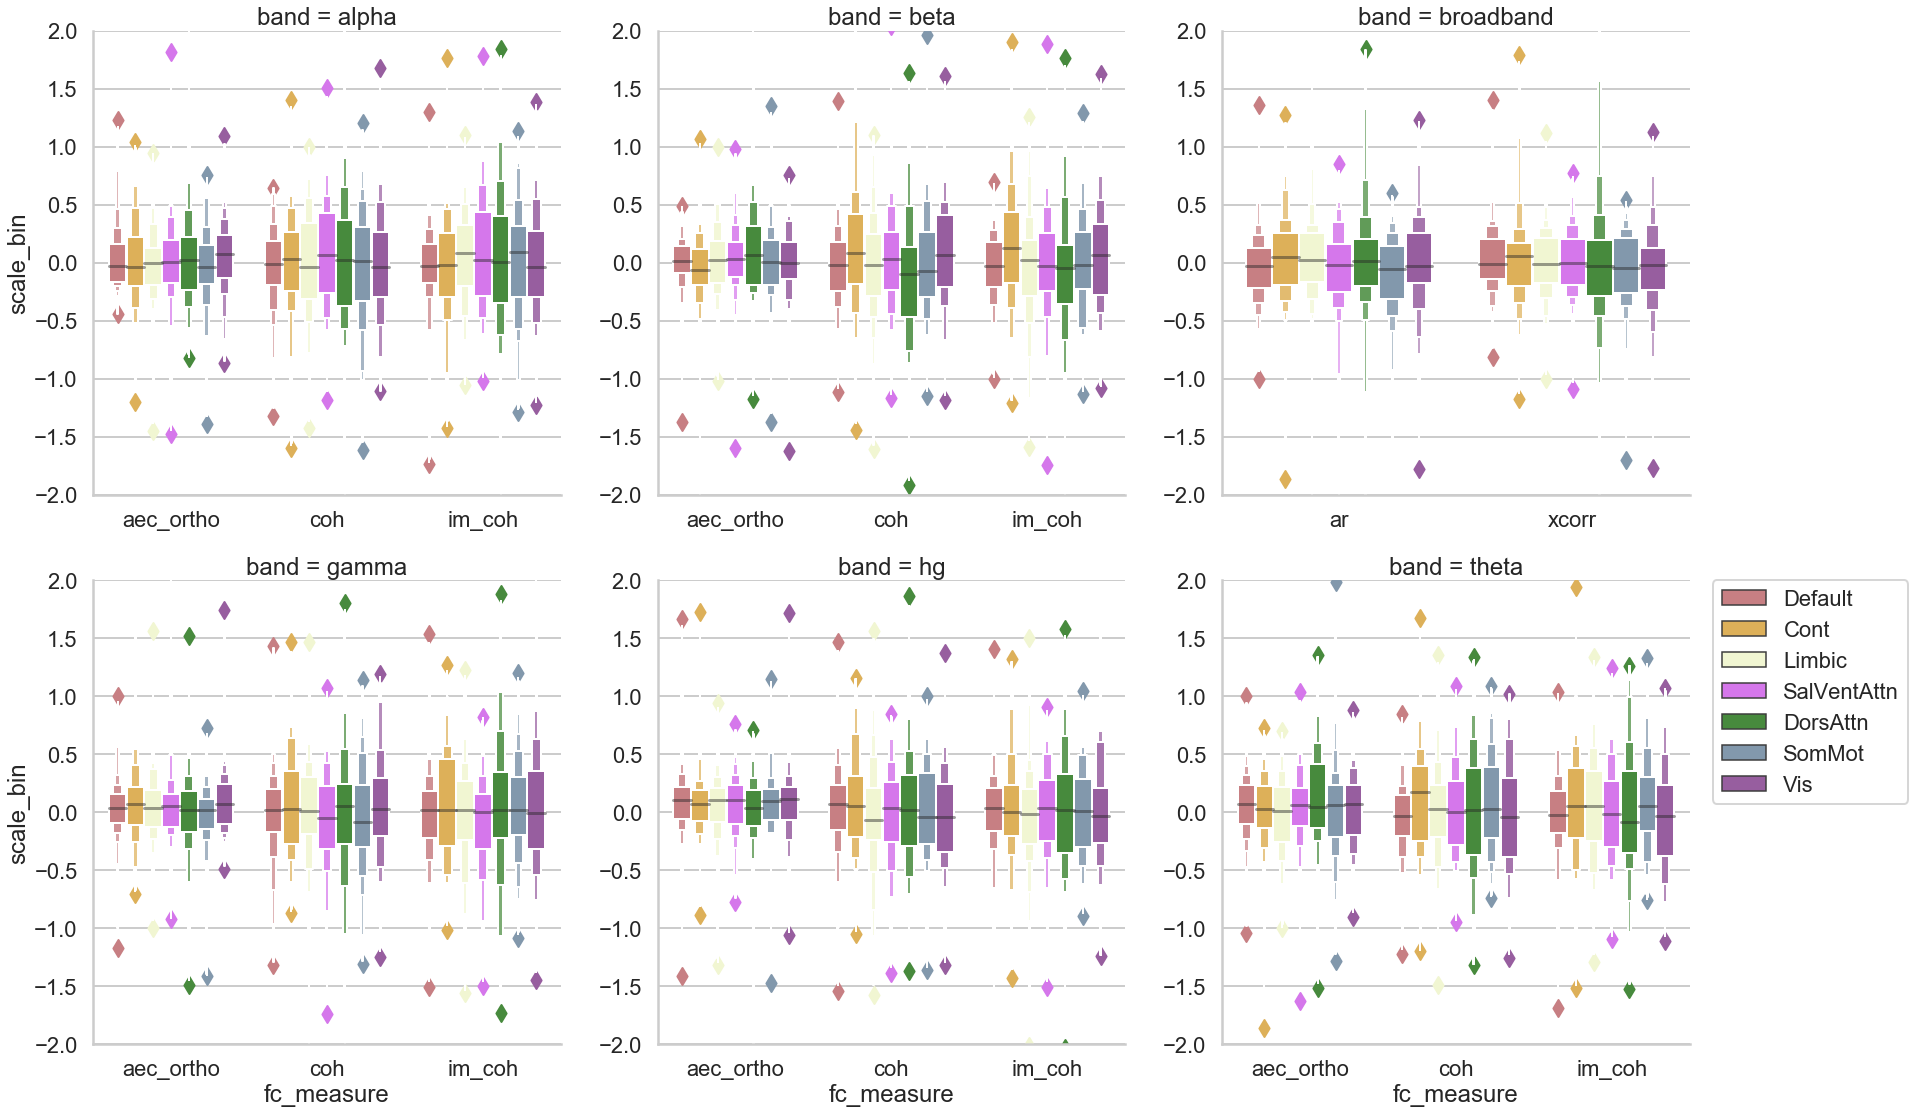

In [86]:
sys_avg = sys_avg[(sys_avg['fc_measure'] != 'aec') & (sys_avg['fc_measure'] != 'plv')]
g = sns.FacetGrid(data=sys_avg, col='band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=8)
g.map(sns.boxenplot, 'fc_measure', 'scale_bin', 'sys', palette = sys_pal,
     hue_order = ['Default', 'Cont', 'Limbic', 'SalVentAttn', 'DorsAttn', 'SomMot', 'Vis'])
g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
for ax in g.axes:
    ax.set_ylim(-2,2)
    
#g.savefig("../img/net_num.eps")

### Categorize SOZ

In [87]:
# check labels of elecs in soz for which sys they are in
flag = 'soz' # spike or soz

epilepsy_type = pd.DataFrame(data={'subj':node_data.subj.unique(), 
                                   'locus':np.empty(node_data.subj.unique().shape),
                                  'hem':np.empty(node_data.subj.unique().shape)})
for index,row in epilepsy_type.iterrows():
    if flag == 'spike':
        curr = node_data[(node_data['subj'] == row.subj)]
        curr = curr[curr['elec_spike'] > 0] #curr[curr['elec_spike'] != 0]['elec_spike'].median()]
    else:
        curr = node_data[(node_data['subj'] == row.subj) & (node_data['elec_in_soz'] == 1)]
    if (np.shape(curr)[0] == 0) | (any(curr.sys.isna())):
        epilepsy_type.loc[index, 'locus'] = np.nan
        epilepsy_type.loc[index,'hem'] = np.nan
    else:
        epilepsy_type.loc[index,'locus'] = curr.sys.mode()[0]
        epilepsy_type.loc[index, 'hem']= curr.hem.mode()[0]
    
epilepsy_type.head()           

subj     locus  hem
0  R1170J  DorsAttn   LH
1  R1284N       NaN  NaN
2  R1276D       NaN  NaN
3  R1263C       NaN  NaN
4  R1260D       NaN  NaN

In [39]:
node_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202146 entries, 0 to 1798985
Data columns (total 34 columns):
elec                      202146 non-null object
band_measure              202146 non-null object
n_tp                      202146 non-null int64
elec_spike                202146 non-null float64
elec_in_soz               202146 non-null int64
scale_bin                 180705 non-null float64
scale_num                 180705 non-null float64
str_soz_beta_bin          144333 non-null float64
str_not_soz_beta_bin      132731 non-null float64
str_spike_beta_bin        143031 non-null float64
str_not_spike_beta_bin    125911 non-null float64
str_beta_bin              199080 non-null float64
str_soz_beta_num          144333 non-null float64
str_not_soz_beta_num      132731 non-null float64
str_spike_beta_num        143031 non-null float64
str_beta_num              199080 non-null float64
str_not_spike_beta_num    125911 non-null float64
fc_measure                202146 non-null ob

In [88]:
epilepsy_type.dropna().subj.nunique()

83

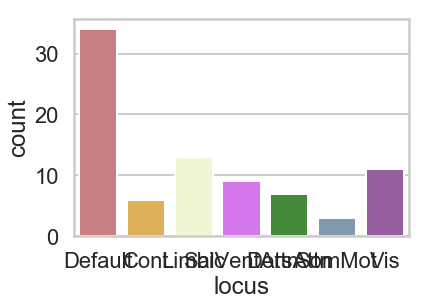

In [89]:
sns.countplot(data=epilepsy_type, x='locus', palette = sys_pal, 
              order = ['Default', 'Cont','Limbic', 'SalVentAttn','DorsAttn', 'SomMot','Vis'],
             hue_order = ['Default', 'Cont', 'Limbic', 'SalVentAttn', 'DorsAttn', 'SomMot', 'Vis'])

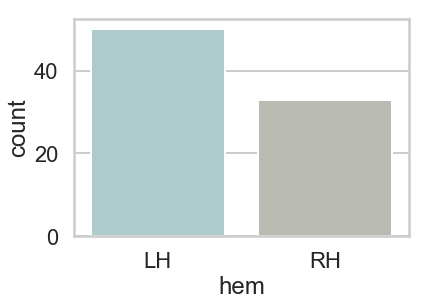

In [90]:
sns.countplot(data=epilepsy_type, x='hem')

In [91]:
# add locus back to big data frames
net_data = pd.merge(net_data, epilepsy_type, on='subj')
node_data = pd.merge(node_data, epilepsy_type, on='subj')
net_data.head()

band_measure  n_tp  str_beta_bin  str_beta_num  str_soz_beta_bin  \
0        alpha_aec   107      0.854233     -0.308418          1.059740   
1  alpha_aec_ortho   107      0.418842     -0.041771          0.139267   
2        alpha_coh   107      0.590071     -0.136139          1.332877   
3     alpha_im_coh   107      0.546350     -0.091240          1.653054   
4        alpha_plv   107      1.382341     -0.571861          0.567091   

   str_soz_beta_num  str_not_soz_beta_num  str_spike_beta_num  \
0         -0.420497             -0.270865           -0.142973   
1         -0.032859             -0.025390            0.200103   
2         -0.490406             -0.045080            0.038881   
3         -0.569317              0.035525           -0.021692   
4         -0.355160             -0.562533           -0.177097   

   str_not_soz_beta_bin  str_spike_beta_bin ...   hand   age  gender race  \
0              0.792757            0.498661 ...      R  20.0       M  2.0   
1              0.288357           -0.733798 ...      R  20.0       M  2.0   
2              0.405967            0.215112 ...      R  20.0       M  2.0   
3              0.269452            0.261294 ...      R  20.0       M  2.0   
4              1.409217            0.125400 ...      R  20.0       M  2.0   

  soz_diff_num soz_diff_bin  spike_diff_num spike_diff_bin     locus  hem  
0    -0.149632     0.266983        0.186936      -0.392536  DorsAttn   LH  
1    -0.007469    -0.149091        0.307216      -1.347489  DorsAttn   LH  
2    -0.445326     0.926910        0.195538      -0.347409  DorsAttn   LH  
3    -0.604842     1.383602        0.075583      -0.250225  DorsAttn   LH  
4     0.207373    -0.842126        0.422241      -1.441778  DorsAttn   LH  

[5 rows x 25 columns]

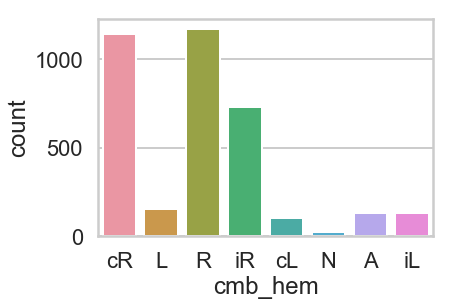

In [92]:
# add combined hand
ipsi = ((net_data['hand'] == 'L') & (net_data['hem'] == 'LH')) | ((net_data['hand'] == 'R') & (net_data['hem'] == 'RH'))
contra = ((net_data['hand'] == 'R') & (net_data['hem'] == 'LH')) | ((net_data['hand'] == 'L') & (net_data['hem'] == 'RH'))

hem_hand = np.empty(np.shape(ipsi), dtype=str)
hem_hand[ipsi] = 'ipsi'
hem_hand[contra] = 'contra'
net_data = net_data.assign(hem_hand=hem_hand)
net_data = net_data.assign(cmb_hem = net_data['hem_hand'] + net_data['hand'])
sns.countplot(net_data.cmb_hem)

In [93]:
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3588 entries, 0 to 3587
Data columns (total 27 columns):
band_measure              3588 non-null object
n_tp                      3588 non-null int64
str_beta_bin              3536 non-null float64
str_beta_num              3536 non-null float64
str_soz_beta_bin          2730 non-null float64
str_soz_beta_num          2730 non-null float64
str_not_soz_beta_num      2720 non-null float64
str_spike_beta_num        2522 non-null float64
str_not_soz_beta_bin      2720 non-null float64
str_spike_beta_bin        2522 non-null float64
str_not_spike_beta_bin    2512 non-null float64
Measure                   3588 non-null object
str_not_spike_beta_num    2512 non-null float64
Frequency Band            3588 non-null object
subj                      3588 non-null object
hand                      3588 non-null object
age                       3588 non-null float64
gender                    3588 non-null object
race                      3588 non-nu

## Net plots with category by locus

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


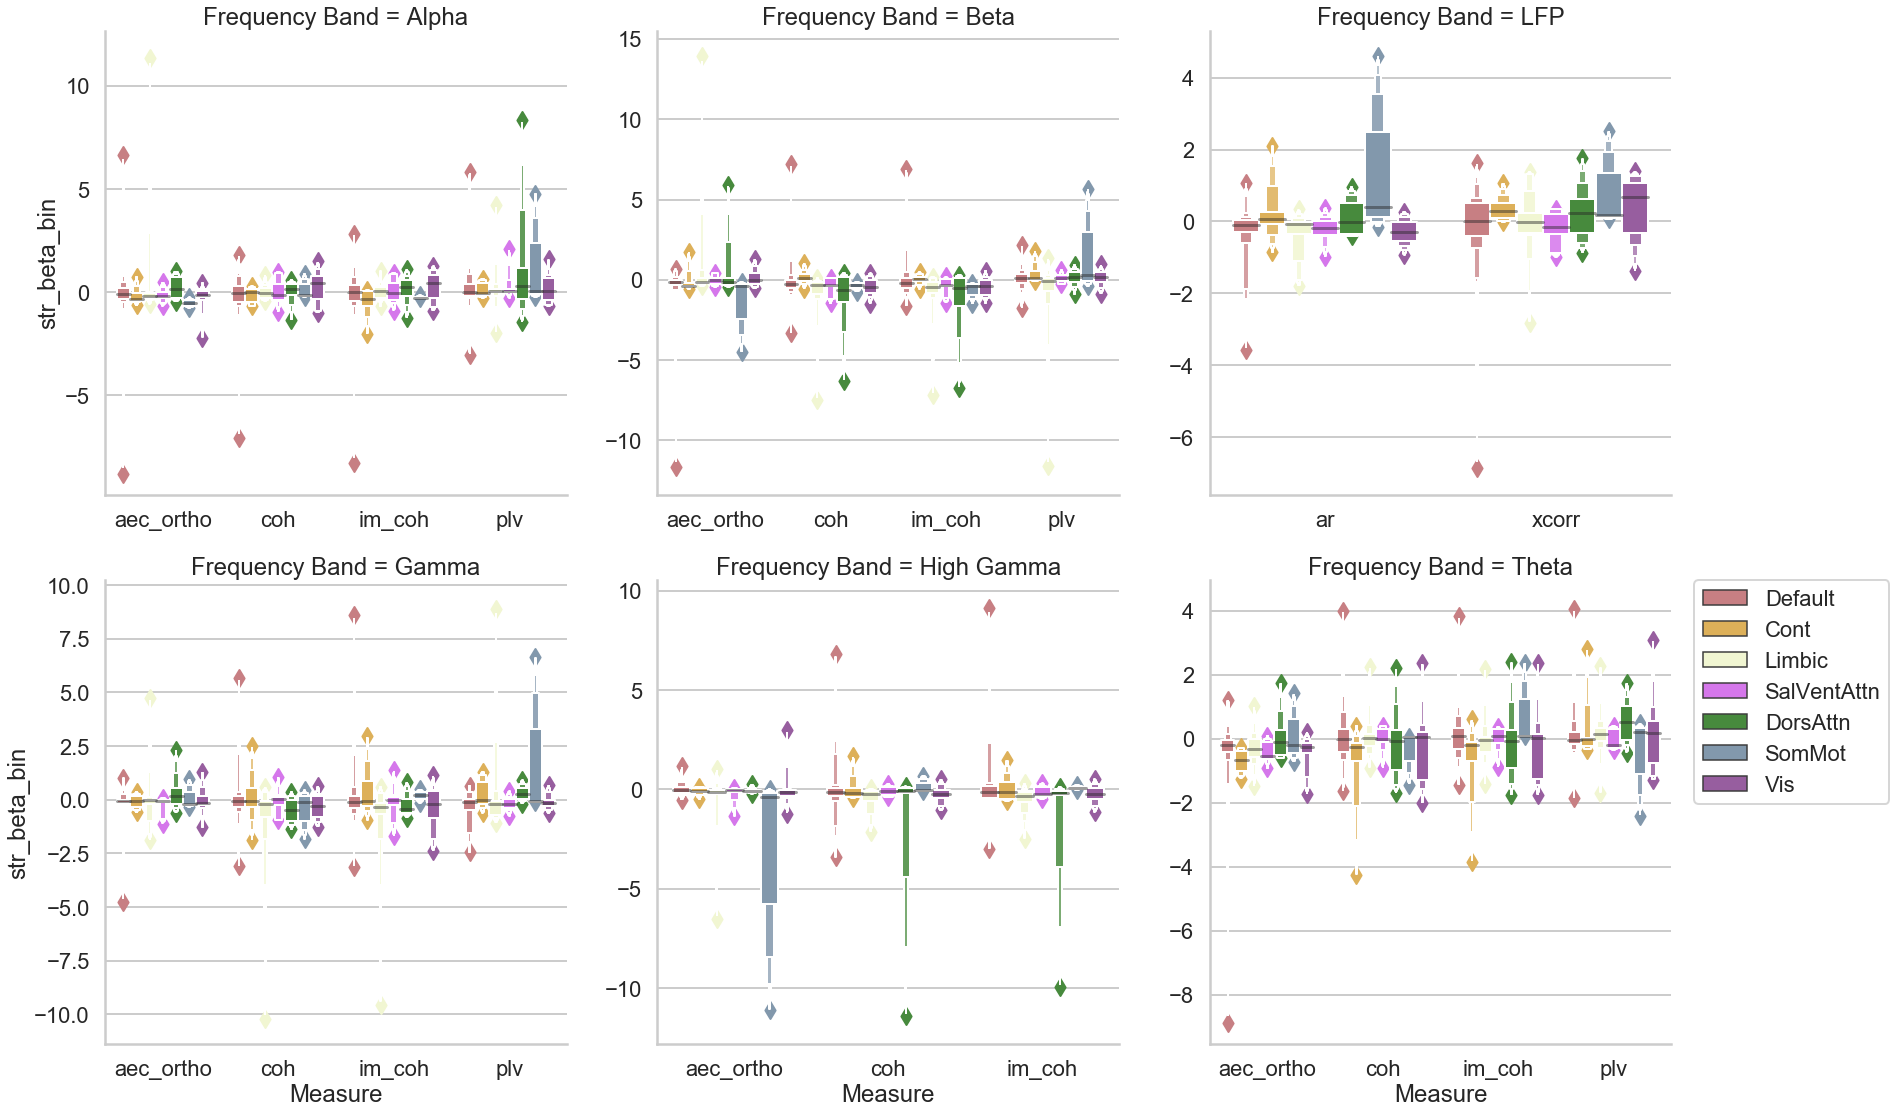

In [96]:
yvar = 'bin'
g = sns.FacetGrid(data=net_data[net_data.Measure != 'aec'], col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=8)
g.map(sns.boxenplot, 'Measure', 'str_beta_' + yvar, 'locus', palette = sys_pal, 
      hue_order = ['Default', 'Cont', 'Limbic', 'SalVentAttn', 'DorsAttn', 'SomMot', 'Vis'])
g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
#for ax in g.axes:
#    ax.set_ylim(-5,5)
    
g.savefig(f'../img/soz_region_{yvar}.png')

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


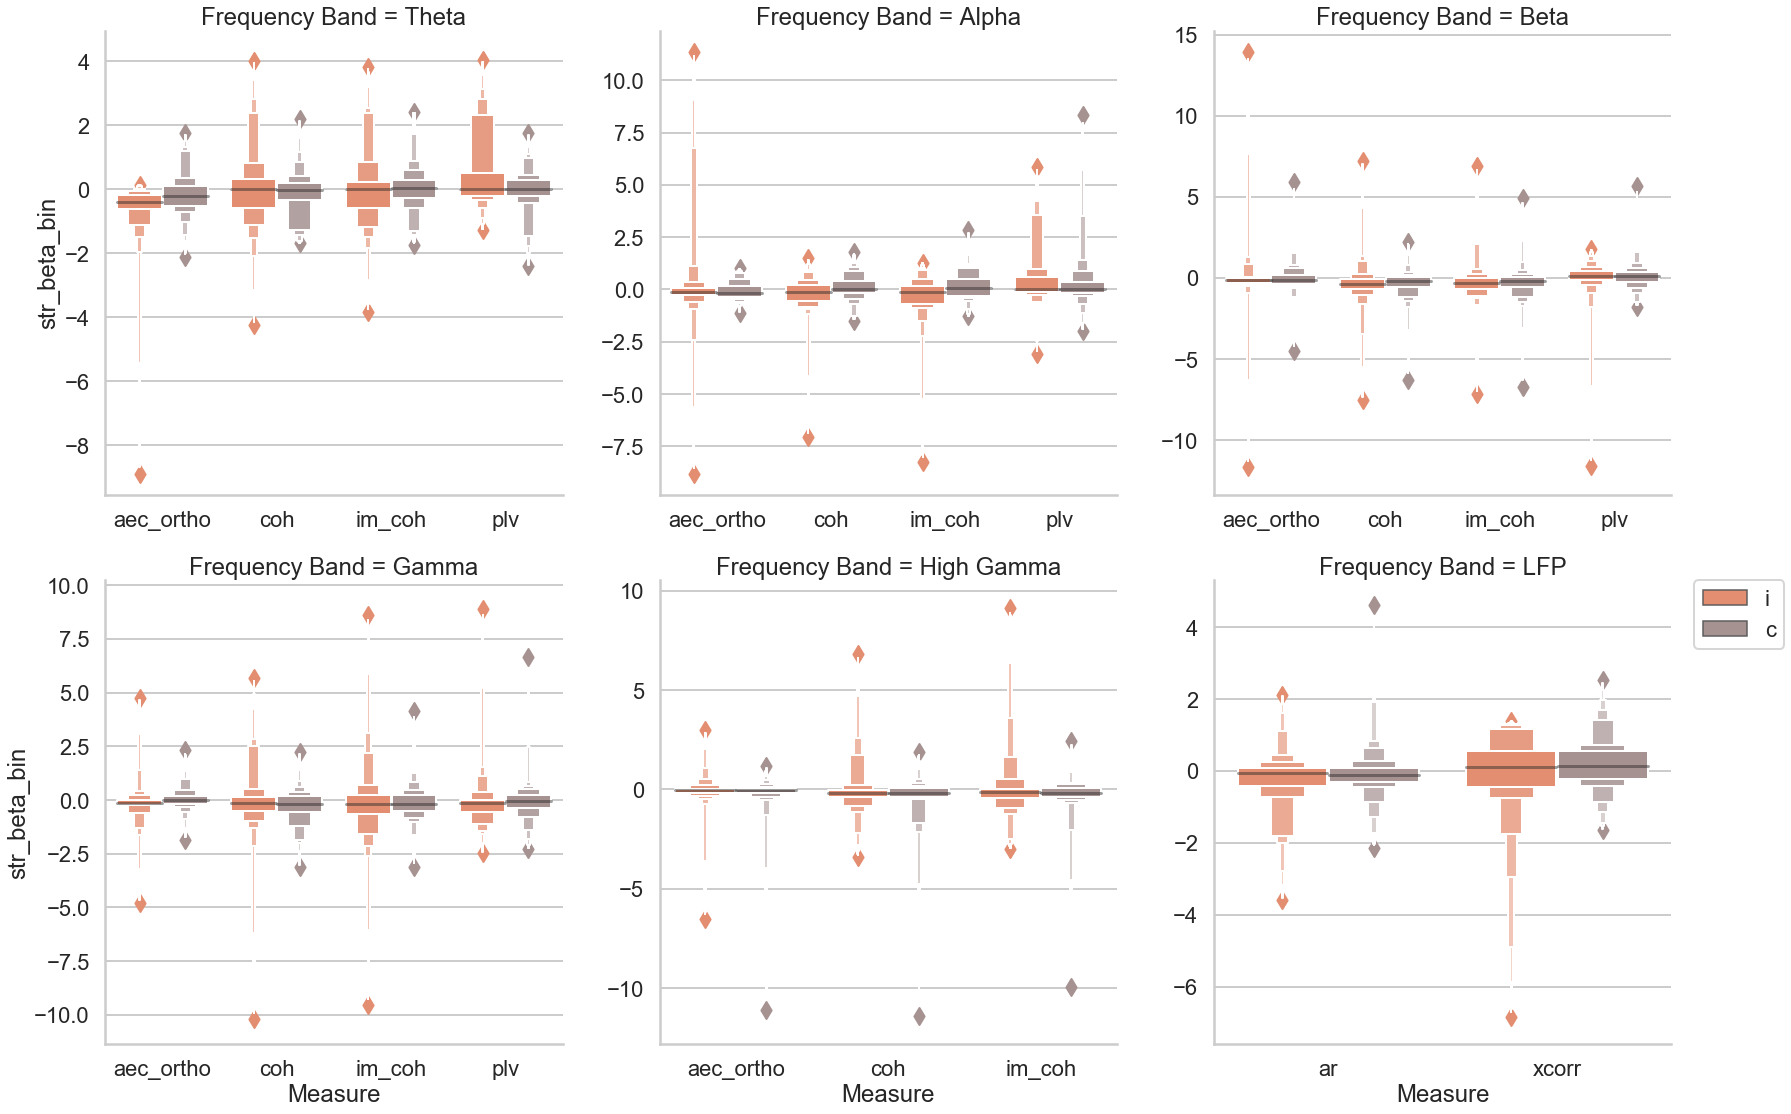

In [98]:
colors = ['#F6855E', '#A98F8E']
yvar = 'bin'
g = sns.FacetGrid(data=net_data[net_data.Measure != 'aec'], col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=8,
                 col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'])
g.map(sns.boxenplot, 'Measure', 'str_beta_' + yvar, 'hem_hand', palette = sns.color_palette(colors), 
      hue_order = ['i', 'c'])
g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)

g.savefig(f"../img/hand_{yvar}{detector}.pdf")

In [99]:
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/sys_{flag}{detector}.csv')

## Behavior

In [100]:
task_data = pd.read_csv(f'{RAM_dir}group_analysis/task_performance.csv', index_col=0)
task_data.reset_index(inplace=True)
task_data.head(10)

subj        YC  TH       PAL  catFR        FR
0  R1001P  0.345526 NaN  0.041370    NaN  0.546573
1  R1002P       NaN NaN  0.492335    NaN  0.945857
2  R1003P       NaN NaN  0.083711    NaN  0.602817
3  R1004D       NaN NaN       NaN  0.625       NaN
4  R1006P  0.401778 NaN       NaN    NaN  0.779412
5  R1008J  0.530724 NaN       NaN    NaN       NaN
6  R1009W  0.183700 NaN       NaN    NaN       NaN
7  R1010J  0.358207 NaN       NaN    NaN  0.825373
8  R1013E  0.182021 NaN       NaN    NaN       NaN
9  R1014D  0.354468 NaN       NaN    NaN       NaN

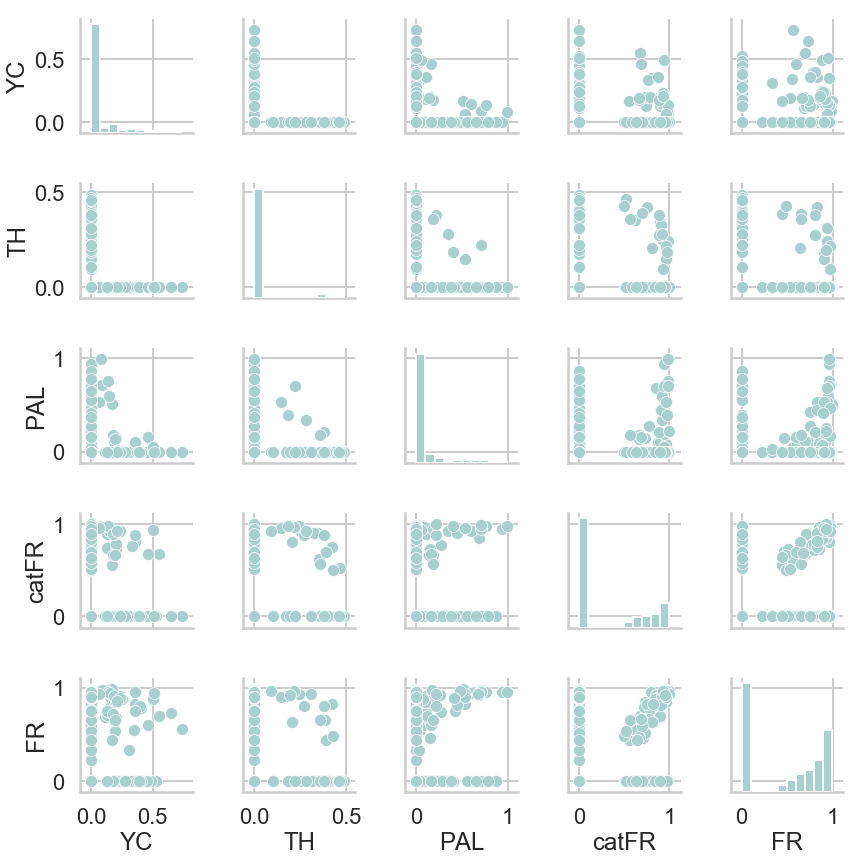

In [64]:
sns.pairplot(data=task_data.fillna(0), vars=['YC','TH','PAL','catFR','FR'])

In [101]:
# add averages over recal and nav tasks
task_data = task_data.assign(recall = task_data[['catFR','FR','PAL']].mean(axis=1, skipna=True))
task_data = task_data.assign(nav = task_data[['TH','YC']].mean(axis=1, skipna=True))
task_data = task_data.assign(scale_nav =  1 - task_data['nav'])
task_data = task_data.assign(avg = task_data[['scale_nav','recall']].mean(axis=1, skipna=True))
task_data.head()

subj        YC  TH       PAL  catFR        FR    recall       nav  \
0  R1001P  0.345526 NaN  0.041370    NaN  0.546573  0.293972  0.345526   
1  R1002P       NaN NaN  0.492335    NaN  0.945857  0.719096       NaN   
2  R1003P       NaN NaN  0.083711    NaN  0.602817  0.343264       NaN   
3  R1004D       NaN NaN       NaN  0.625       NaN  0.625000       NaN   
4  R1006P  0.401778 NaN       NaN    NaN  0.779412  0.779412  0.401778   

   scale_nav       avg  
0   0.654474  0.474223  
1        NaN  0.719096  
2        NaN  0.343264  
3        NaN  0.625000  
4   0.598222  0.688817

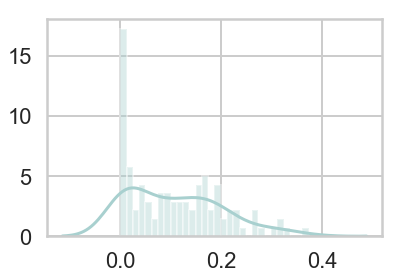

In [102]:
# Are subjects variable across tasks? 
var = pd.core.nanops.nanvar(task_data[['TH', 'YC', 'PAL', 'FR', 'catFR']], axis=1)
var = var[task_data[['TH', 'YC', 'PAL', 'FR', 'catFR']].isna().sum(axis=1) <= 3]
sns.distplot(var, bins=30)

In [118]:
# only keep subjects who completed at least 3
task_data = task_data[task_data[['TH', 'YC', 'PAL','FR', 'catFR']].isna().sum(axis=1) <= 3]
task_data.subj.nunique()

79

In [119]:
# merge with net_data
subj_idx = [x in net_data.subj.unique() for x in task_data.subj]
task_data = task_data[subj_idx]
net_task_data = pd.merge(net_data, task_data, on=['subj'])
net_task_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 0 to 2079
Data columns (total 36 columns):
band_measure              2080 non-null object
n_tp                      2080 non-null int64
str_beta_bin              2054 non-null float64
str_beta_num              2054 non-null float64
str_soz_beta_bin          1716 non-null float64
str_soz_beta_num          1716 non-null float64
str_not_soz_beta_num      1710 non-null float64
str_spike_beta_num        1586 non-null float64
str_not_soz_beta_bin      1710 non-null float64
str_spike_beta_bin        1586 non-null float64
str_not_spike_beta_bin    1580 non-null float64
Measure                   2080 non-null object
str_not_spike_beta_num    1580 non-null float64
Frequency Band            2080 non-null object
subj                      2080 non-null object
hand                      2080 non-null object
age                       2080 non-null float64
gender                    2080 non-null object
race                      2080 non-nu

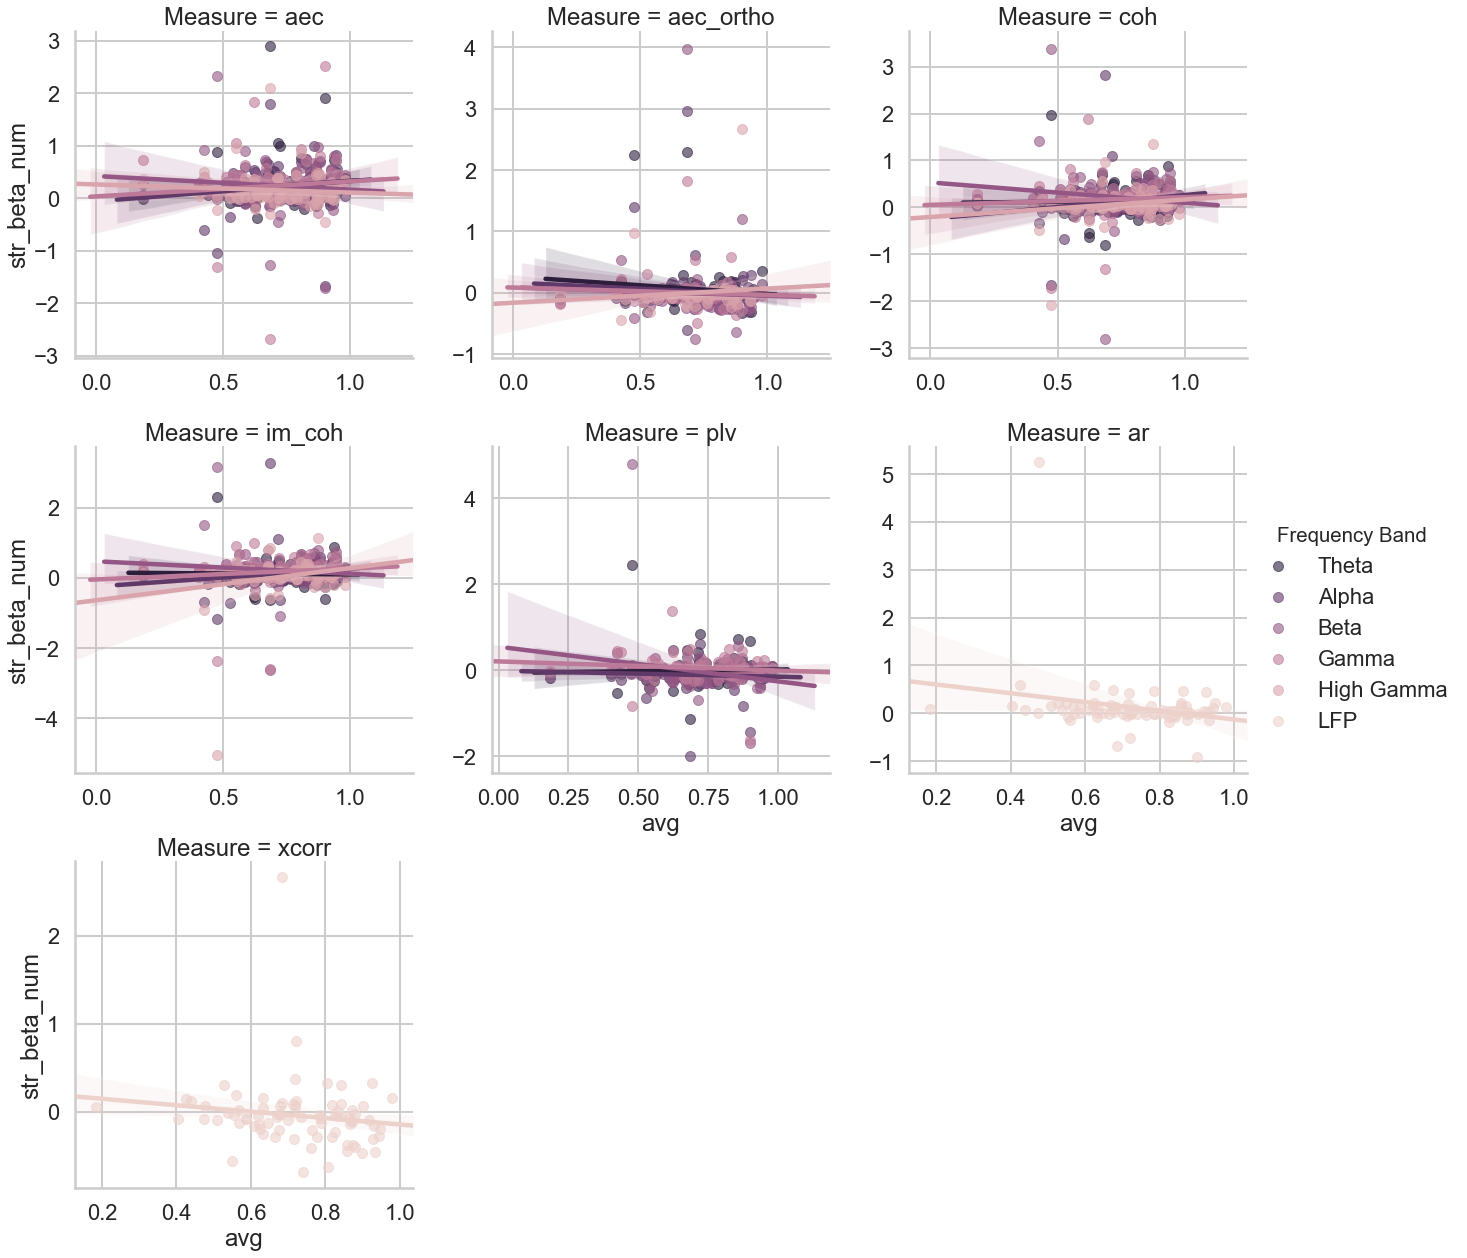

In [120]:
yvar='num'
sns.lmplot(data=net_task_data, x='avg', y='str_beta_' + yvar, hue='Frequency Band', col="Measure", 
           col_wrap=3, height=6, sharex=False, sharey=False, 
           palette=sns.color_palette(sns.cubehelix_palette(6, reverse=True)), 
           scatter_kws={'s':100, 'alpha':.6}, 
           hue_order=['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'])
#plt.savefig(f"../img/avg_behavior_{yvar}{detector}.pdf")

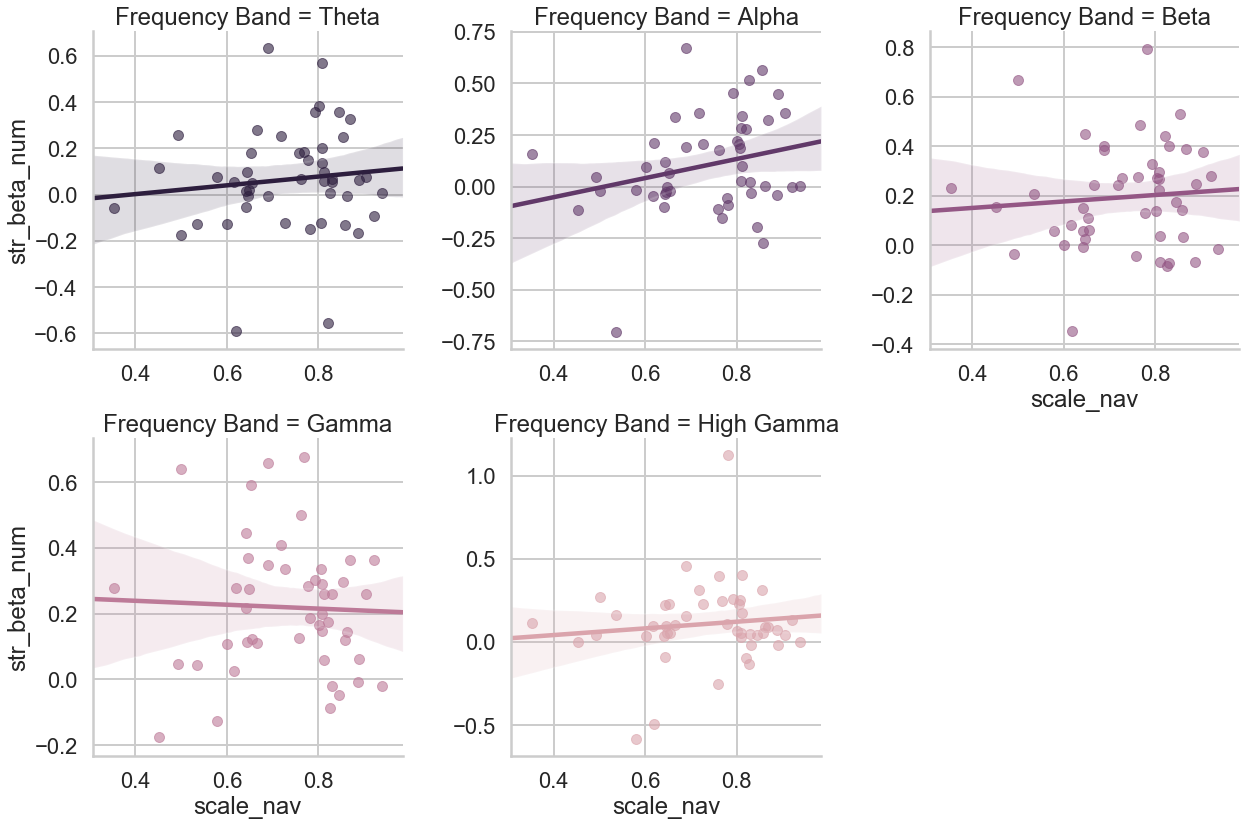

In [121]:
sns.lmplot(data=net_task_data[net_task_data['Measure'] == 'im_coh'], x='scale_nav', y='str_beta_num', hue='Frequency Band', col="Frequency Band", 
           col_wrap=3, height=6, sharex=False, sharey=False, 
           palette=sns.color_palette(sns.cubehelix_palette(6, reverse=True)),
           hue_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'],
           scatter_kws={'s':100, 'alpha':.6}, col_order=['Theta','Alpha','Beta','Gamma','High Gamma'])
#plt.savefig(f"../img/task_perf_band{detector}.eps")

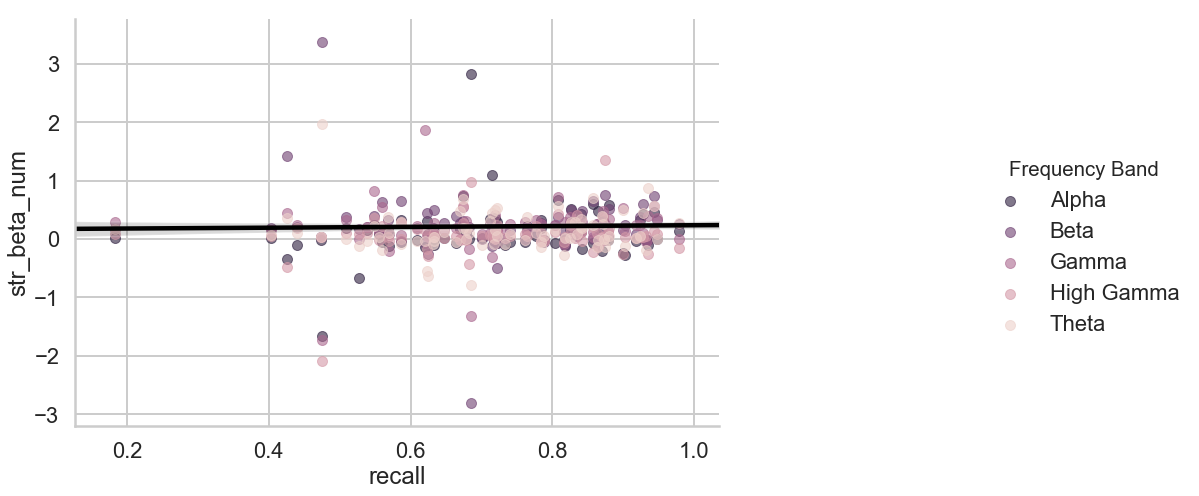

In [122]:
g = sns.lmplot(data=net_task_data[net_task_data['Measure'] == 'coh'], x='avg', y='str_beta_num', hue='Frequency Band', fit_reg=False,
           height=6, sharex=False, sharey=False, palette=sns.color_palette(sns.cubehelix_palette(5, reverse= True)), 
               scatter_kws={'s':100, 'alpha':.6})
sns.regplot(data=net_task_data[net_task_data['Measure'] == 'aec'], x='recall', y='str_beta_num', scatter=False, ax=g.axes[0,0], color='black')
g.fig.set_figwidth(20)
g.fig.set_figheight(8)
plt.savefig(f"../img/task_perf_band{detector}.eps")

In [123]:
# save
net_task_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_task_data_clean{detector}.csv')

In [114]:
# load residual
resid = pd.read_csv(f'{RAM_dir}group_analysis/win_{win}/resid{detector}.csv')
resid.head()

Unnamed: 0    subj Measure  resid_num  resid_bin   Band       nav    recall
0           1  R1170J     aec        NaN   1.733619  Alpha       NaN  0.649084
1           2  R1284N     aec        NaN  -0.185847  Alpha       NaN  0.232143
2           3  R1284N     aec        NaN  -0.196431  Alpha       NaN  0.155556
3           4  R1276D     aec        NaN   0.477822  Alpha  0.778258  0.702573
4           5  R1276D     aec        NaN   0.483309  Alpha  0.780118       NaN

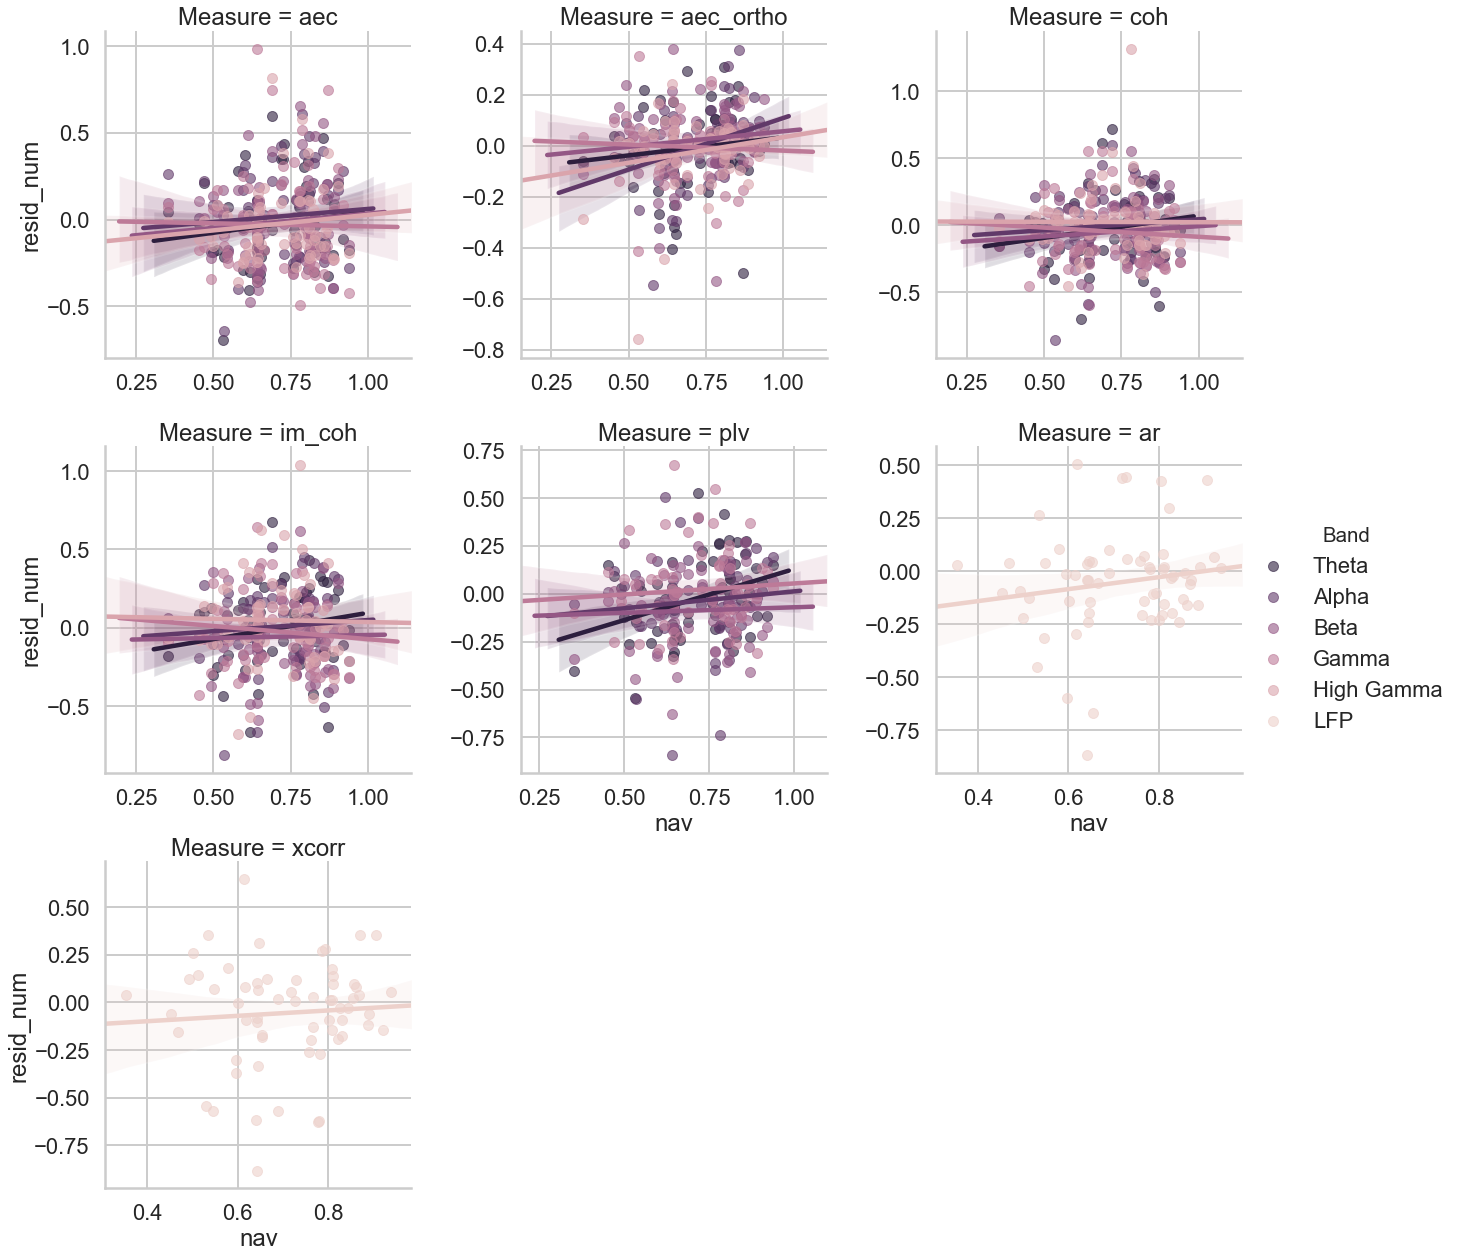

In [115]:
yvar='num'
t = 'nav'
sns.lmplot(data=resid, x=t, y='resid_' + yvar, hue='Band', col="Measure", 
           col_wrap=3, height=6, sharex=False, sharey=False, 
           palette=sns.color_palette(sns.cubehelix_palette(6, reverse=True)), 
           scatter_kws={'s':100, 'alpha':.6}, 
           hue_order=['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'])
plt.savefig(f"../img/{t}_behavior_{yvar}_{detector}.png")

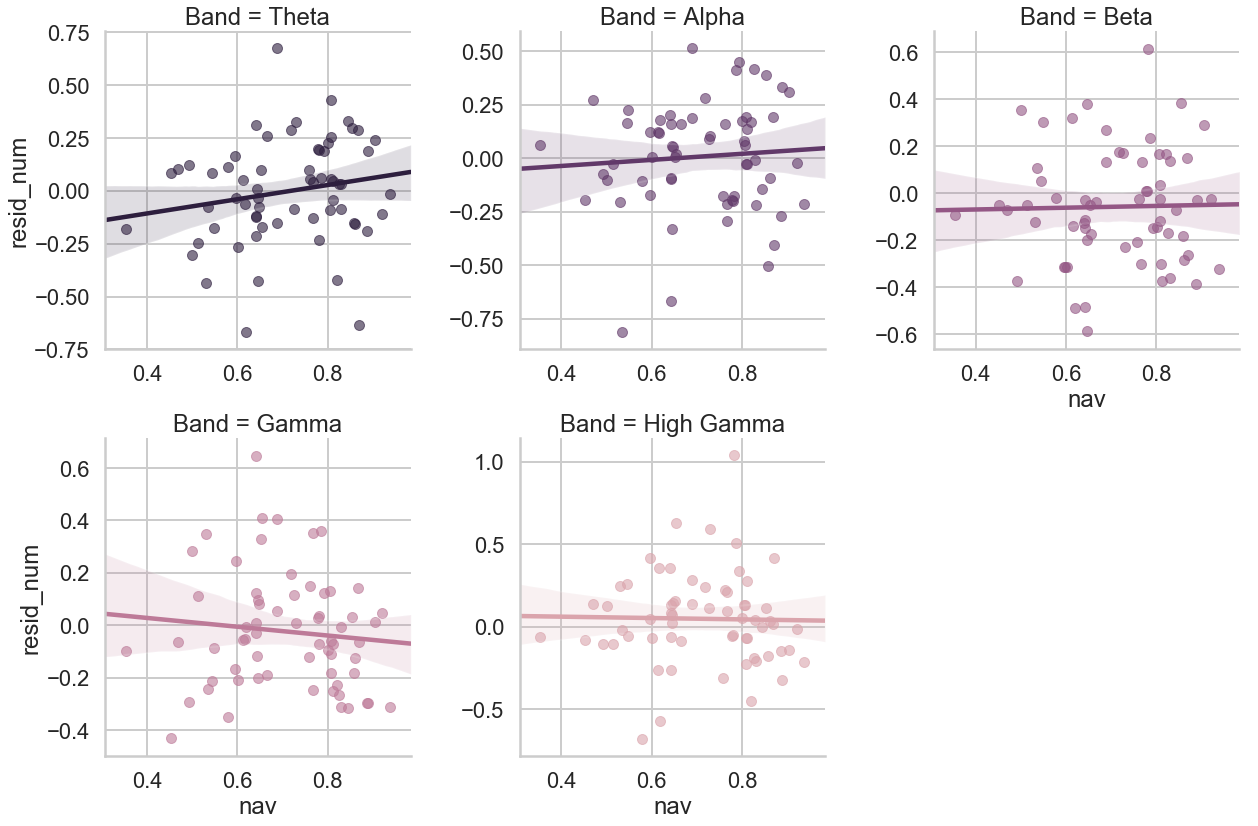

In [117]:
sns.lmplot(data=resid[resid['Measure'] == 'im_coh'], x='nav', y='resid_num', hue='Band', col="Band", 
           col_wrap=3, height=6, sharex=False, sharey=False, 
           palette=sns.color_palette(sns.cubehelix_palette(6, reverse=True)),
           hue_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'],
           scatter_kws={'s':100, 'alpha':.6}, col_order=['Theta','Alpha','Beta','Gamma','High Gamma'])
plt.savefig(f"../img/task_perf_band{detector}.png")

Other parameters

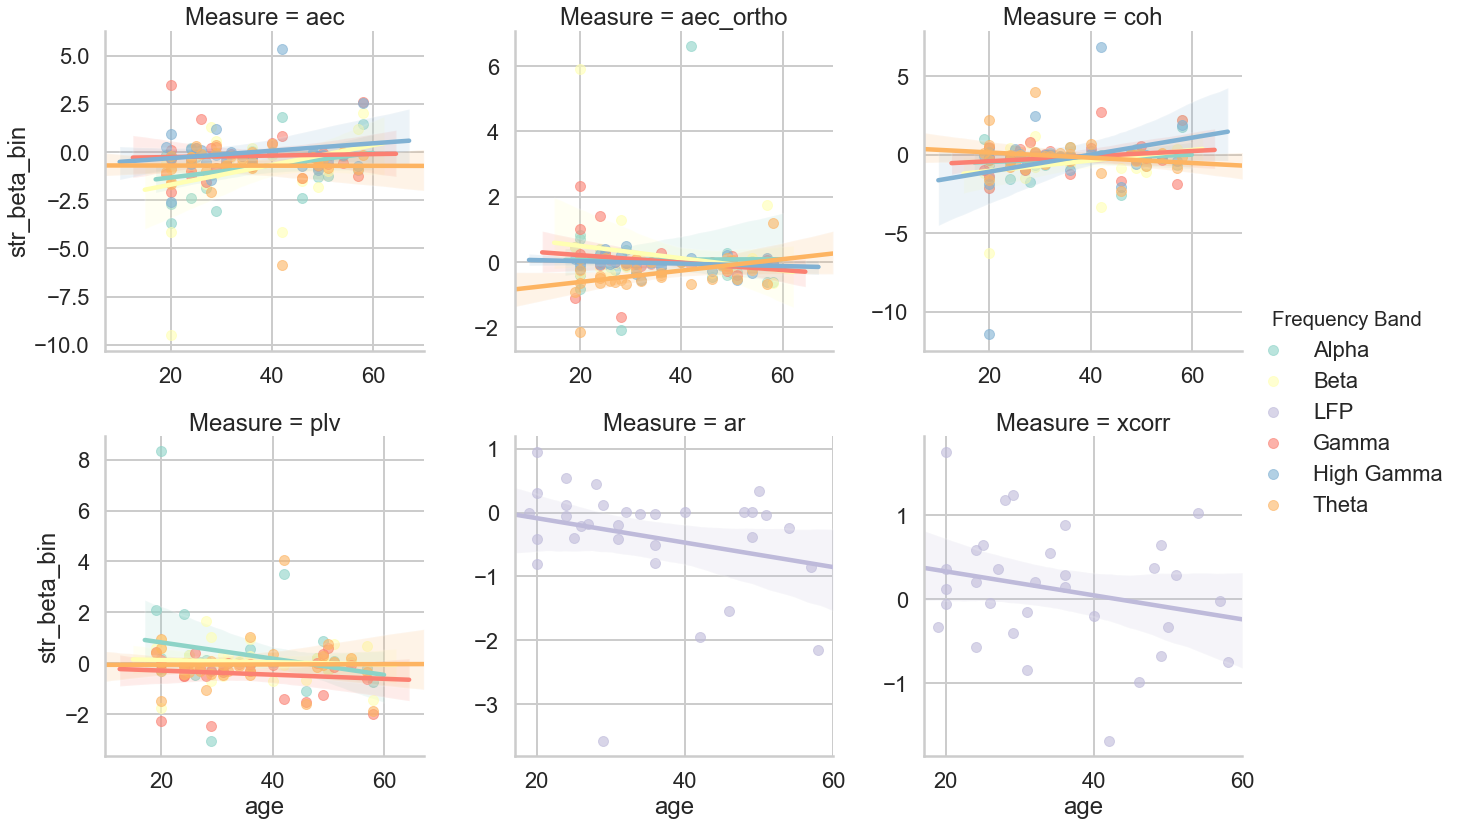

In [497]:
sns.lmplot(data=net_task_data, x='age', y='str_beta_bin', hue='Frequency Band', col="Measure", 
           col_wrap=3, height=6, sharex=False, sharey=False, palette='Set3', scatter_kws={'s':100, 'alpha':.6})

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


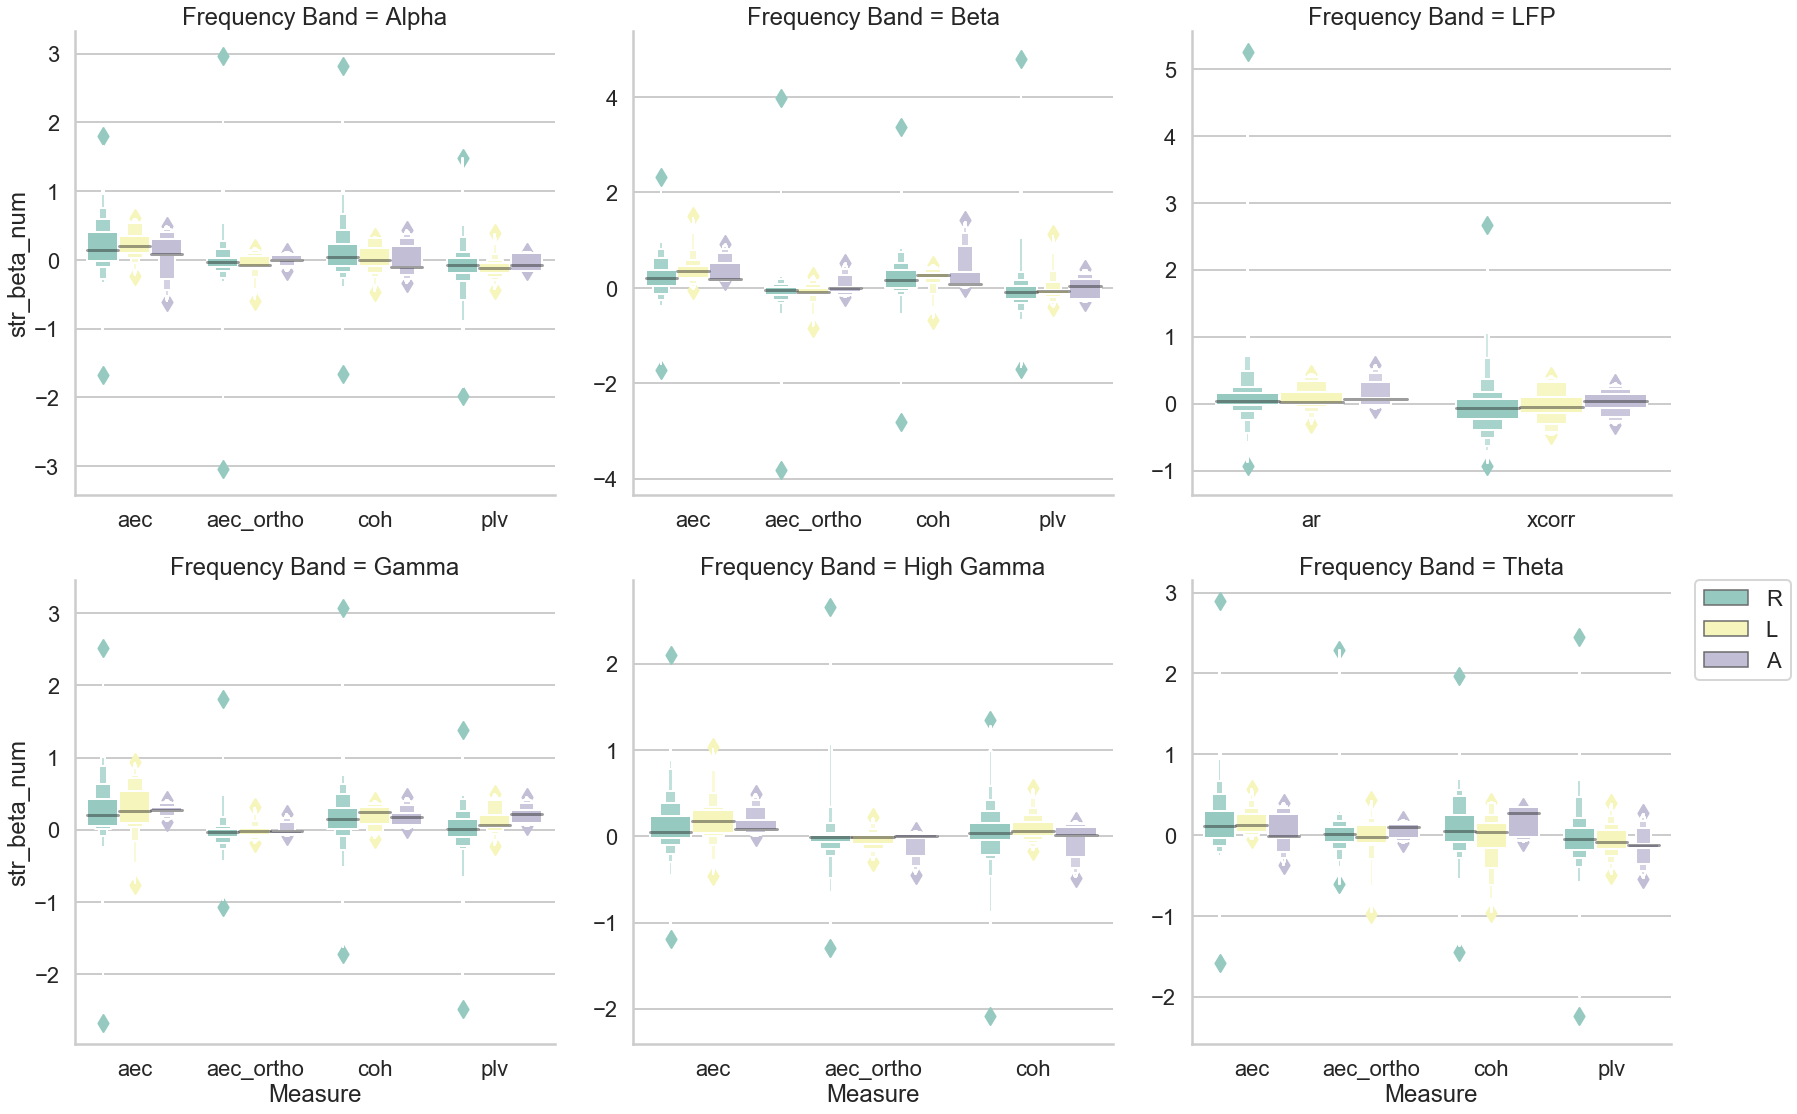

In [498]:
g = sns.FacetGrid(data=net_data, col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=8)
g.map(sns.boxenplot, 'Measure', 'str_beta_num', 'hand', palette = "Set3", hue_order=['R','L', 'A'])
#g.map(sns.stripplot, 'fc_measure', 'spike_beta_num', 'spike',jitter=True, dodge=True,
#              alpha=.2, zorder=1, size=6, hue_order=['str_spike_beta_num','str_not_spike_beta_num'])
# g.axes[0].set_xticklabels(g.axes[0].xaxis.get_majorticklabels(),rotation=30)
# g.axes[1].set_xticklabels(g.axes[1].xaxis.get_majorticklabels(),rotation=30)
# g.axes[2].set_xticklabels(g.axes[2].xaxis.get_majorticklabels(),rotation=30)
g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)